In [1]:
import os, json

from others.utils import read_airland_file, generate_separation_between_runways, save_solution
from models.MIP import solve_single_runway_mip, solve_multiple_runways_mip
from models.CP import solve_single_runway_cp, solve_multiple_runways_cp
from models.CP_MIP import solve_hybrid_lbbd
from ortools.sat.python import cp_model

In [2]:
data_dir = "data"
r_max = 5
num_files = 8
output_json = "results/metrics.json"
solutions_json = "results/solutions.json"

# Results

### Justificação para o report

**Dataset 9** represents a critical scalability threshold for the MIP formulation of the aircraft landing problem. With **100 aircraft** and a **large freeze-time (720)**, the model already exhibits a substantial increase in both the number of decision variables and constraints. This growth is mainly driven by the quadratic expansion of binary sequencing variables. From this dataset onward, the computational burden increases dramatically, clearly highlighting the practical limitations of exact MIP approaches for large-scale instances.

#### MIP Model Size per Dataset

| Dataset | Number of Aircraft | Decision Variables | Constraints | Estimated Runtime |
| ------: | -----------------: | -----------------: | ----------: | ----------------: |
|       9 |                100 |             10,200 |      12,019 |              Days |
|      10 |                150 |             22,800 |      25,569 |      Days / Weeks |
|      11 |                200 |             40,400 |      44,184 |    Weeks / Months |
|      12 |                250 |             63,000 |      67,977 |    Months / Years |
|      13 |                500 |            251,000 |     261,552 |       Impractical |

The computational results clearly show the exponential growth in complexity of the exact MIP formulation for the aircraft landing problem. While instances with up to 50 aircraft can be solved to optimality within seconds, doubling the number of aircraft to 100 already leads to solution times of several hours, especially under large freeze-time windows (e.g., 720). This behaviour is explained by the quadratic number of binary sequencing variables and the resulting exponential branch-and-bound search space. Based on empirical evidence and theoretical complexity, instances with 150 or more aircraft become computationally intractable for exact MIP solvers, with expected solution times ranging from days to months or even longer. Therefore, large-scale instances are unsuitable for exact optimization and must instead be addressed using time-limited approaches, heuristic methods, or alternative formulations.


## MIP

### Single Runway

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["MIP Single"] = []

for i in range(1, num_files + 1):
    file_name = f"airland{i}.txt"
    file_path = os.path.join(data_dir, file_name)

    print("\n" + "="*60)
    print(f"Processing file: {file_name}")
    print("="*60 + "\n")

    data = read_airland_file(file_path)

    solver, variables, metrics = solve_single_runway_mip(data['p'], data['planes'], data['separation_times'], hint=True, performance=True)

    save_solution(
        solver = solver,
        variables=variables,
        num_planes=data['p'],
        data=data['planes'],
        solution_file=solutions_json,
        tag="MIP Single",
        dataset_name=file_name
    )

    metrics_with_file = {"file": file_name, **metrics}
    all_metrics["MIP Single"].append(metrics_with_file)

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table:")
print("{:<12} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "File", "Exec Time(s)", "Variables", "Constraints", "Total Penalty", "B&B Nodes"
))
for m in all_metrics["MIP Single"]:
    print("{:<12} {:<15.4f} {:<15} {:<15} {:<15} {:<15}".format(
        m["file"], m["execution_time"], m["num_variables"],
        m["num_constraints"], m["total_penalty"], m["num_branch_and_bound_nodes"]
    ))



Processing file: airland1.txt

		Creating Single Runway MIP Model

-> Decision variables: 120
-> Constraints: 205

			Solving MIP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest
-------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00
    1 |       258.00 |   195.00 | 258.00 | 744.00
    2 |        98.00 |    89.00 |  98.00 | 510.00
    3 |       106.00 |    96.00 | 106.00 | 521.00
    4 |       118.00 |   110.00 | 123.00 | 555.00
    5 |       126.00 |   120.00 | 135.00 | 576.00
    6 |       134.00 |   124.00 | 138.00 | 577.00
    7 |       142.00 |   126.00 | 140.00 | 573.00
    8 |       150.00 |   135.00 | 150.00 | 591.00
    9 |       180.00 |   160.00 | 180.00 | 657.00

-> Planes that did not land on the target time:
Plane | Landing Time | Target | Early Dev | Late Dev | Penalty
--------------------------------------------------------------
    0 |       165.00 | 155.00 |      0.00 |    10.00 |  100.0

### Multiple Runways

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["MIP Multiple"] = []

for i in range(1, num_files + 1):
    file_name = f"airland{i}.txt"
    file_path = os.path.join(data_dir, file_name)

    print("\n" + "="*60)
    print(f"Processing file: {file_name}")
    print("="*60 + "\n")

    data = read_airland_file(file_path)

    for r in range(1, r_max + 1):
        print(f"\n---> Solving with {r} runways...\n")
        separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
        solver, variables, metrics = solve_multiple_runways_mip(data['p'], r, data['planes'], data['separation_times'], separation_times_between_runways,
                                                   hint=True, performance=True)

        penalty = metrics["total_penalty"]
        print(f"Runways={r} -> Total Penalty={penalty}")

        save_solution(
            solver = solver,
            variables=variables,
            num_planes=data['p'],
            data=data['planes'],
            solution_file=solutions_json,
            tag="MIP Multiple",
            dataset_name=file_name,
            num_runways=r
        )

        metrics_with_file = {"file": file_name, "num_runways": r, **metrics}
        all_metrics["MIP Multiple"].append(metrics_with_file)

        # Interrupt if zero penalty is found
        if penalty == 0:
            break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (MIP Multiple):")
header = "{:<12} {:<18} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "File", "Number of Runways", "Exec Time(s)", "Variables", "Constraints", "Total Penalty", "B&B Nodes"
)
print(header)
print("-" * len(header))

for m in all_metrics["MIP Multiple"]:
    print("{:<12} {:<18} {:<15.4f} {:<15} {:<15} {:<15} {:<15}".format(
        m["file"], m["num_runways"], m["execution_time"], m["num_variables"],
        m["num_constraints"], m["total_penalty"], m["num_branch_and_bound_nodes"]
    ))



Processing file: airland1.txt


---> Solving with 1 runways...

		Creating Multiple Runways MIP Solver

-> Decision variables: 220
-> Constraints: 395

			Solving MIP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest | Runway
----------------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00 |      0
    1 |       258.00 |   195.00 | 258.00 | 744.00 |      0
    2 |        98.00 |    89.00 |  98.00 | 510.00 |      0
    3 |       106.00 |    96.00 | 106.00 | 521.00 |      0
    4 |       118.00 |   110.00 | 123.00 | 555.00 |      0
    5 |       126.00 |   120.00 | 135.00 | 576.00 |      0
    6 |       134.00 |   124.00 | 138.00 | 577.00 |      0
    7 |       142.00 |   126.00 | 140.00 | 573.00 |      0
    8 |       150.00 |   135.00 | 150.00 | 591.00 |      0
    9 |       180.00 |   160.00 | 180.00 | 657.00 |      0

-> Planes that did not land on the target time:
Plane | Landing Time | Target | Early Dev 

### Large Datasets

In [6]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["MIP Multiple Large Datasets"] = []

# Values of runways to test for each dataset, based on prior knowledge
runways = {'9': [3,4], '10': [4,5], '11': [5], '12': [6], '13': [7]}

for i in range(9, 14):
    file_name = f"airland{i}.txt"
    file_path = os.path.join(data_dir, file_name)

    print("\n" + "="*60)
    print(f"Processing file: {file_name}")
    print("="*60 + "\n")

    data = read_airland_file(file_path)

    for r in runways[str(i)]:
        print(f"\n---> Solving with {r} runways...\n")
        separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
        solver, variables, metrics = solve_multiple_runways_mip(data['p'], r, data['planes'], data['separation_times'], separation_times_between_runways,
                                                   hint=True, performance=True)

        penalty = metrics["total_penalty"]
        print(f"Runways={r} -> Total Penalty={abs(penalty):.2f}")

        save_solution(
            solver = solver,
            variables=variables,
            num_planes=data['p'],
            data=data['planes'],
            solution_file=solutions_json,
            tag="MIP Multiple Large Datasets",
            dataset_name=file_name,
            num_runways=r
        )

        metrics_with_file = {"file": file_name, "num_runways": r, **metrics}
        all_metrics["MIP Multiple Large Datasets"].append(metrics_with_file)

        # Interrupt if zero penalty is found
        if penalty == 0:
            break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (MIP Multiple Large Datasets):")
header = "{:<12} {:<18} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "File", "Number of Runways", "Exec Time(s)", "Variables", "Constraints", "Total Penalty", "B&B Nodes"
)
print(header)
print("-" * len(header))

for m in all_metrics["MIP Multiple Large Datasets"]:
    print("{:<12} {:<18} {:<15.4f} {:<15} {:<15} {:<15} {:<15}".format(
        m["file"], m["num_runways"], m["execution_time"], m["num_variables"],
        m["num_constraints"], abs(m["total_penalty"]), m["num_branch_and_bound_nodes"]
    ))



Processing file: airland9.txt


---> Solving with 3 runways...

		Creating Multiple Runways MIP Solver

-> Decision variables: 20400
-> Constraints: 34643

			Solving MIP

-> Landing times of all planes:
Plane | Landing Time | Earliest |   Target |   Latest | Runway
--------------------------------------------------------------
    0 |       908.00 |   601.00 |   908.00 |  2401.00 |      0
    1 |      1027.00 |   725.00 |  1027.00 |  2525.00 |      2
    2 |      1378.00 |   928.00 |  1378.00 |  2728.00 |      2
    3 |      1502.00 |   974.00 |  1502.00 |  2774.00 |      0
    4 |      1618.00 |  1056.00 |  1618.00 |  2856.00 |      2
    5 |      1235.00 |  1119.00 |  1235.00 |  2919.00 |      2
    6 |      1520.00 |  1148.00 |  1520.00 |  2948.00 |      2
    7 |      1401.00 |  1195.00 |  1401.00 |  2995.00 |      1
    8 |      1584.00 |  1201.00 |  1584.00 |  3001.00 |      1
    9 |      1343.00 |  1218.00 |  1343.00 |  3018.00 |      0
   10 |      1787.00 |  1224.00 |  1787

## CP

### Single Runway

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["CP Single"] = []

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"CP Single - Strategy {name}"

    for i in range(1, num_files + 1):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        solver, model, variables, metrics = solve_single_runway_cp(
            data['p'], data['planes'], data['separation_times'], hint=True, search_strategy=strategy, performance=True)

        save_solution(
            solver = solver,
            variables=variables,
            num_planes=data['p'],
            data=data['planes'],
            solution_file=solutions_json,
            tag = tag,
            dataset_name=file_name
        )

        metrics_with_file = {"file": file_name, "strategy": name, **metrics}
        all_metrics["CP Single"].append(metrics_with_file)

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (CP Single):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Strategy", "Exec Time(s)", "Memory Usage", "Status", "Conflicts", "Branches", "Booleans", "Best Objective Bound", "Variables", "Constraints"
))
for m in all_metrics["CP Single"]:
    print("{:<12} {:<18} {:<18.4f} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["strategy"], m["execution_time"], m["memory_usage"],
        m["solution_status"], m["num_conflicts"], m["num_branches"],
        m["num_booleans"], m["best_objective_bound"], m["num_variables"], m["num_constraints"]
    ))


=== Testing strategy: Automatic Search ===


Processing file: airland1.txt

		     Creating CP model

-> Number of decision variables created: 75
-> Number of constraints: 130

			Solving CP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest
-------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00
    1 |       258.00 |   195.00 | 258.00 | 744.00
    2 |        98.00 |    89.00 |  98.00 | 510.00
    3 |       106.00 |    96.00 | 106.00 | 521.00
    4 |       118.00 |   110.00 | 123.00 | 555.00
    5 |       126.00 |   120.00 | 135.00 | 576.00
    6 |       134.00 |   124.00 | 138.00 | 577.00
    7 |       142.00 |   126.00 | 140.00 | 573.00
    8 |       150.00 |   135.00 | 150.00 | 591.00
    9 |       180.00 |   160.00 | 180.00 | 657.00

-> Planes that did not land on the target time:
Plane | Landing Time | Target | Early Dev | Late Dev | Penalty
--------------------------------------------------------------


### Multiple Runway

In [4]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["CP Multiple"] = []

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"CP Multiple - Strategy {name}"

    for i in range(1, num_files + 1):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in range(1, r_max + 1):
            print(f"\n---> Solving with {r} runways...\n")
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, variables, metrics = solve_multiple_runways_cp(data['p'], r, data['planes'], data['separation_times'],
                                                                separation_times_between_runways, hint=True, search_strategy=strategy, performance=True)

            penalty = metrics["best_objective_bound"]
            print(f"Runways={r} -> Best Objective Bound={penalty}")

            save_solution(
                solver = solver,
                variables=variables,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["CP Multiple"].append(metrics_with_file)

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (CP Multiple):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Strategy", "Num_runways", "Exec Time(s)", "Memory Usage", "Status", "Conflicts", "Branches", "Booleans", "Best Obj. Bound", "Variables", "Constraints"
))
for m in all_metrics["CP Multiple"]:
    print("{:<12} {:<18} {:<18.4f} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["strategy"], m["num_runways"], m["execution_time"], m["memory_usage"],
        m["solution_status"], m["num_conflicts"], m["num_branches"],
        m["num_booleans"], m["best_objective_bound"], m["num_variables"], m["num_constraints"]
    ))


=== Testing strategy: Automatic Search ===


Processing file: airland1.txt


---> Solving with 1 runways...

		     Creating CP model

-> Number of decision variables created: 130
-> Number of constraints: 320

			Solving CP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest | Runway
----------------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00 |      0
    1 |       258.00 |   195.00 | 258.00 | 744.00 |      0
    2 |        98.00 |    89.00 |  98.00 | 510.00 |      0
    3 |       106.00 |    96.00 | 106.00 | 521.00 |      0
    4 |       118.00 |   110.00 | 123.00 | 555.00 |      0
    5 |       126.00 |   120.00 | 135.00 | 576.00 |      0
    6 |       134.00 |   124.00 | 138.00 | 577.00 |      0
    7 |       142.00 |   126.00 | 140.00 | 573.00 |      0
    8 |       150.00 |   135.00 | 150.00 | 591.00 |      0
    9 |       180.00 |   160.00 | 180.00 | 657.00 |      0

-> Planes that did not land on t

### Large Datasets

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["CP Multiple Large Datasets"] = []

# Values of runways to test for each dataset, based on prior knowledge
runways = {'9': [3,4], '10': [4,5], '11': [5], '12': [6], '13': [7]}

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"CP Multiple Large Datasets - Strategy {name}"

    for i in range(9, 14):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in runways[str(i)]:
            print(f"\n---> Solving with {r} runways...\n")
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, variables, metrics = solve_multiple_runways_cp(data['p'], r, data['planes'], data['separation_times'], separation_times_between_runways,
                                                    hint=True, search_strategy=strategy, performance=True)

            penalty = metrics["best_objective_bound"]
            print(f"Runways={r} -> Best Objective Bound={abs(penalty):.2f}")

            save_solution(
                solver = solver,
                variables=variables,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["CP Multiple Large Datasets"].append(metrics_with_file)

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (CP Multiple Large Datasets):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Strategy", "Num_runways", "Exec Time(s)", "Memory Usage", "Status", "Conflicts", "Branches", "Booleans", "Best Obj. Bound", "Variables", "Constraints"
))
for m in all_metrics["CP Multiple Large Datasets"]:
    print("{:<12} {:<18} {:<18.4f} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18.2f} {:<18.2f}".format(
        m["file"], m["strategy"], m["num_runways"], m["execution_time"], m["memory_usage"],
        m["solution_status"], m["num_conflicts"], m["num_branches"],
        m["num_booleans"], m["best_objective_bound"], m["num_variables"], m["num_constraints"]
    ))



=== Testing strategy: Automatic Search ===


Processing file: airland9.txt


---> Solving with 3 runways...

		     Creating CP model

-> Number of decision variables created: 10300
-> Number of constraints: 15962

			Solving CP

-> Landing times of all planes:
Plane | Landing Time | Earliest |   Target |   Latest | Runway
--------------------------------------------------------------
    0 |       908.00 |   601.00 |   908.00 |  2401.00 |      2
    1 |      1027.00 |   725.00 |  1027.00 |  2525.00 |      2
    2 |      1378.00 |   928.00 |  1378.00 |  2728.00 |      0
    3 |      1502.00 |   974.00 |  1502.00 |  2774.00 |      1
    4 |      1618.00 |  1056.00 |  1618.00 |  2856.00 |      2
    5 |      1235.00 |  1119.00 |  1235.00 |  2919.00 |      2
    6 |      1520.00 |  1148.00 |  1520.00 |  2948.00 |      2
    7 |      1401.00 |  1195.00 |  1401.00 |  2995.00 |      2
    8 |      1584.00 |  1201.00 |  1584.00 |  3001.00 |      0
    9 |      1343.00 |  1218.00 |  1343.00 |

## Hybrid CP-MIP

In [5]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["Hybrid"] = []

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"Hybrid - Strategy {name}"

    for i in range(1, num_files + 1):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in range(1, r_max + 1):
            print(f"\n---> Solving with {r} runways...\n")
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, fixed_runways, sp_times, metrics = solve_hybrid_lbbd(data['p'], r, data['planes'], data['separation_times'],
                                                                separation_times_between_runways, max_iterations=50, search_strategy=strategy, performance=True)

            penalty = metrics["total_best_objective_bound"]
            print(f"Runways={r} -> Total Penalty={penalty}")

            save_solution(
                solver = None,
                variables=None,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r,
                landing_times_override=sp_times,
                fixed_runways=fixed_runways
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["Hybrid"].append(metrics_with_file)

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (Hybrid):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Best Obj. Bound", "Strategy", "Num_runways", "Iterations", "Converged", "Exec Time(s)", "CP Time(s)", "MIP Time(s)", "MIP Calls", "Branches", "Conflicts", "Booleans", "Variables", "Constraints", "Memory Usage (MB)"
))
for m in all_metrics["Hybrid"]:
    print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["total_best_objective_bound"], m["strategy"], m["num_runways"], m["num_iterations"], m["converged"], m["total_time"],
        m["cp_time"], m["mip_time"], m["mip_num_calls"], m["cp_num_branches"], m["cp_num_conflicts"],
        m["cp_num_booleans"], m["cp_num_variables"], m["cp_num_constraints"], m["memory_start_MB"]
    ))


=== Testing strategy: Automatic Search ===


Processing file: airland1.txt


---> Solving with 1 runways...


		Running Hybrid LBBD Solver (Strengthened Master)

--- Iteration 1 ---
  >> Master Theta: 700 | Subproblem Real Cost: 701
  >> Gap found. Adding Optimality Cut.
--- Iteration 2 ---
  >> Master Theta: 700 | Subproblem Real Cost: 700

*** CONVERGENCE ACHIEVED in 2 iterations! ***

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest | Runway
----------------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00 |      1
    1 |       258.00 |   195.00 | 258.00 | 744.00 |      1
    2 |        98.00 |    89.00 |  98.00 | 510.00 |      1
    3 |       106.00 |    96.00 | 106.00 | 521.00 |      1
    4 |       118.00 |   110.00 | 123.00 | 555.00 |      1
    5 |       126.00 |   120.00 | 135.00 | 576.00 |      1
    6 |       134.00 |   124.00 | 138.00 | 577.00 |      1
    7 |       142.00 |   126.00 | 140.00 | 57

### Large Datasets

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["Hybrid Large Datasets"] = []

# Values of runways to test for each dataset, based on prior knowledge
runways = {'9': [3,4], '10': [4,5], '11': [5], '12': [6], '13': [7]}

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"Hybrid Large Datasets - Strategy {name}"

    for i in range(9, 14):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in runways[str(i)]:
            print(f"\n---> Solving with {r} runways...\n")

            max_iter = 5
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, fixed_runways, sp_times, metrics = solve_hybrid_lbbd(data['p'], r, data['planes'], data['separation_times'],
                                                                separation_times_between_runways, max_iterations=max_iter, search_strategy=strategy, performance=True)

            penalty = metrics["total_best_objective_bound"]
            print(f"Runways={r} -> Total Penalty={abs(penalty):.2f}")

            save_solution(
                solver = None,
                variables=None,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r,
                landing_times_override=sp_times,
                fixed_runways=fixed_runways
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["Hybrid Large Datasets"].append(metrics_with_file)
            m = metrics_with_file
            print(
               "File:", m["file"],
               "\nBest Obj. Bound:", m["total_best_objective_bound"],
               "\nStrategy:", m["strategy"],
               "\nNum_runways:", m["num_runways"],
               "\nNum_iterations:", m["num_iterations"],
               "\nConverged:", m["converged"],
               "\nExec Time(s):", m["total_time"],
               "\nCP_time:", m["cp_time"],
               "\nMIP Time(s):", m["mip_time"],
               "\nMIP Calls:", m["mip_num_calls"],
               "\nBranches:", m["cp_num_branches"],
               "\nConflicts:", m["cp_num_conflicts"],
               "\nBooleans:", m["cp_num_booleans"],
               "\nVariables:", m["cp_num_variables"],
               "\nConstraints:", m["cp_num_constraints"],
               "\nMemory Usage (MB):", m["memory_start_MB"]
            )

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (Hybrid Large Datasets):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Best Obj. Bound", "Strategy", "Num_runways", "Iterations", "Converged", "Exec Time(s)", "CP Time(s)", "MIP Time(s)", "MIP Calls", "Branches", "Conflicts", "Booleans", "Variables", "Constraints", "Memory Usage (MB)"
))

for m in all_metrics["Hybrid Large Datasets"]:
    print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["total_best_objective_bound"], m["strategy"], m["num_runways"], m["num_iterations"], m["converged"], m["total_time"],
        m["cp_time"], m["mip_time"], m["mip_num_calls"], m["cp_num_branches"], m["cp_num_conflicts"],
        m["cp_num_booleans"], m["cp_num_variables"], m["cp_num_constraints"], m["memory_start_MB"]
    ))



=== Testing strategy: Automatic Search ===


Processing file: airland9.txt


---> Solving with 3 runways...


		Running Hybrid LBBD Solver (Strengthened Master)

--- Iteration 1 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 2 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 3 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 4 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 5 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
Runways=3 -> Total Penalty=75.75
File: airland9.txt 
Best Obj. Bound: 75.75 
Strategy: Automatic Search 
Num_runways: 3 
Num_iterations: 5 
Converged: False 
Exec Time(s): 41.3386903 
CP_time: 38.6658853 
MIP Time(s): 2.0222979 
MIP Calls: 5 
Branches: 159482 
Conflicts: 0 
Booleans: 14156 
Varia

# Analysis

In [ ]:
import re
import json
import dash
import pandas as pd
import numpy as np
from dash import dcc, html, dash_table

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

import warnings
warnings.filterwarnings("ignore")

## Load results

In [162]:
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

def load_metrics_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_metrics_table(metrics_data: dict, num_airplanes: dict) -> pd.DataFrame:
    rows = []

    for solver, records in metrics_data.items():
        for rec in records:
            file = rec.get("file", "unknown")
            n_planes = num_airplanes.get(file, "—")
            num_runways = rec.get("num_runways", 1)
            strategy = rec.get("strategy", "—")

            exec_time = (
                rec.get("execution_time") or
                rec.get("total_time") or
                rec.get("cp_time") or
                rec.get("mip_time") or
                None
            )

            memory = (
                rec.get("memory_usage_MB") or
                rec.get("memory_usage") or
                rec.get("memory_start_MB") or
                None
            )

            penalty = (
                rec.get("total_penalty") or
                rec.get("best_objective_bound") or
                rec.get("total_best_objective_bound")
            )
            if penalty is not None:
                penalty = round(penalty)

            num_vars = rec.get("num_variables") or rec.get("cp_num_variables")
            num_cons = rec.get("num_constraints") or rec.get("cp_num_constraints")

            num_branches = (
                rec.get("num_branch_and_bound_nodes") or
                rec.get("num_branches") or
                rec.get("cp_num_branches")
            )

            row = {
                "Dataset": file,
                "#Planes": n_planes,
                "#Runways": num_runways,
                "Solver": solver,
                "Strategy": strategy,
                "Time (s)": exec_time,
                "Memory (MB)": memory,
                "Penalty / Obj": penalty,
                "#Variables": num_vars,
                "#Constraints": num_cons,
                "#Branches": num_branches,
                "Converged": rec.get("converged", rec.get("solution_status", "—")),
                "Num Conflicts": rec.get("num_conflicts", rec.get("cp_num_conflicts", "—")),
                "Num Booleans": rec.get("num_booleans", rec.get("cp_num_booleans","—")),
                "Num Iterations": rec.get("num_iterations", "—"),
                "MIP Num Calls": rec.get("mip_num_calls", "—")
            }

            rows.append(row)

    df = pd.DataFrame(rows)

    df["Solver"] = df["Solver"].replace({
        "MIP Multiple Large Datasets": "MIP Multiple",
        "CP Multiple Large Datasets": "CP Multiple",
        "Hybrid Large Datasets": "Hybrid"
    })

    return df


In [ ]:
# ============================================
# 1) Load JSON
# ============================================
METRICS_PATH = Path("results/metrics.json")

with open(METRICS_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

list(raw.keys())[:10], len(raw)

# ============================================
# 2) Helpers: parsing keys + safe numeric
# ============================================

def parse_key(key: str) -> dict:
    """
    Convert a key like "MIP Single" or "CP Multiple - Strategy X" into structured info.
    Returns a dict with:
    - model_family: "MIP", "CP", "Hybrid", or "Unknown"
    - scenario: rest of the key after model_family
    - model_key: original key
    """
    key = key.strip()

    # model_family
    m = re.match(r"^(MIP|CP|Hybrid)\b", key, re.IGNORECASE)
    model_family = m.group(1).upper() if m else "Unknown"

    # scenario
    scenario = key[len(m.group(0)):].strip() if m else key

    # normalize spaces
    scenario = re.sub(r"\s+", " ", scenario).strip()
    return {"model_family": model_family, "scenario": scenario, "model_key": key}


def to_numeric_safe(series: pd.Series) -> pd.Series:
    """Convert to numeric, keeping NaNs when conversion fails."""
    return pd.to_numeric(series, errors="coerce")


def ensure_columns(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Ensure columns exist (create with NaN if missing)."""
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

# ============================================
# 3) Normalization into a flat DataFrame
# ============================================

rows = []

for key, items in raw.items():
    meta = parse_key(key)

    if not isinstance(items, list):
        continue

    for item in items:
        if not isinstance(item, dict):
            continue
        row = {}
        row.update(meta)
        row.update(item)
        rows.append(row)

df = pd.DataFrame(rows)

# ---- Make common columns ----
common_cols = [
    "file",
    "runways",
    "execution_time",
    "memory_usage_MB",
    "num_variables",
    "num_constraints",
    "total_penalty",
]
df = ensure_columns(df, common_cols)

# ---- Make specific columns (MIP/CP/Hybrid) ----
mip_cols = ["num_branch_and_bound_nodes"]
cp_cols = ["num_branches", "num_conflicts", "num_booleans", "best_objective_bound", "solution_status"]
hyb_cols = [
    "num_iterations", "converged",
    "cp_total_time", "cp_num_branches", "cp_num_conflicts", "cp_num_booleans", "cp_num_variables", "cp_num_constraints",
    "mip_total_time", "mip_num_calls",
    "peak_memory_usage", "memory_overhead",
    "total_wall_time"
]
df = ensure_columns(df, mip_cols + cp_cols + hyb_cols)

# ---- Numeric types ----
num_cols = [
    "runways", "execution_time", "memory_usage_MB",
    "num_variables", "num_constraints", "total_penalty",
    "num_branch_and_bound_nodes",
    "num_branches", "num_conflicts", "num_booleans", "best_objective_bound",
    "num_iterations", "cp_total_time", "cp_num_branches", "cp_num_conflicts", "cp_num_booleans",
    "cp_num_variables", "cp_num_constraints",
    "mip_total_time", "mip_num_calls",
    "peak_memory_usage", "memory_overhead", "total_wall_time",
]
for c in num_cols:
    df[c] = to_numeric_safe(df[c])

# ---- Runways: if missing, assume 1 for Single ----
is_single = df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)
df.loc[is_single & df["runways"].isna(), "runways"] = 1

# ---- Time and memory: normalize to the same field (useful for Hybrid later) ----
# If Hybrid uses total_wall_time / peak_memory_usage, fallback automatically.
df["wall_time_s"] = df["execution_time"]
df.loc[df["wall_time_s"].isna() & df["total_wall_time"].notna(), "wall_time_s"] = df["total_wall_time"]

df["memory_MB"] = df["memory_usage_MB"]
df.loc[df["memory_MB"].isna() & df["peak_memory_usage"].notna(), "memory_MB"] = df["peak_memory_usage"]

# ============================================
# 4) Cleaning/consistency + useful IDs (FIX)
# ============================================

# ensure strings
df["file"] = df["file"].astype(str)
df["scenario"] = df["scenario"].astype(str)

# --- runways: global rule ---
# Single -> 1
is_single = df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)
df.loc[is_single & df["runways"].isna(), "runways"] = 1

# Other cases (Multiple / Large) without explicit runways:
# use -1 as a semantic placeholder ("undefined")
df["runways"] = df["runways"].fillna(-1)

# keep runways as integer *after* resolving NaNs
df["runways"] = df["runways"].astype(int)

# --- experimental instance id ---
df["instance_id"] = (
    df["file"]
    + " | RW=" + df["runways"].astype(str)
    + " | " + df["scenario"]
)

# ============================================
# 5) Comparable derived metrics (base for charts)
# ============================================

# avoid division by zero
eps = 1e-12

# --- best objective per instance (file+runways+scenario) ---
# (if there are models without solution/NaN, min automatically ignores NaN)
best_penalty = (
    df.groupby("instance_id")["total_penalty"]
      .min()
      .rename("best_penalty")
      .reset_index()
)

df = df.merge(best_penalty, on="instance_id", how="left")

df["regret"] = df["total_penalty"] - df["best_penalty"]
df["relative_gap"] = df["regret"] / (df["best_penalty"] + eps)

# --- search intensities (when available) ---
df["mip_nodes_per_sec"] = df["num_branch_and_bound_nodes"] / (df["wall_time_s"] + eps)
df["cp_branches_per_sec"] = df["num_branches"] / (df["wall_time_s"] + eps)

# conflicts per 1000 branches (when available)
df["cp_conflicts_per_1k_branches"] = df["num_conflicts"] / ((df["num_branches"] / 1000.0) + eps)

# --- time/memory normalizations by size ---
df["time_per_1k_vars"] = df["wall_time_s"] / ((df["num_variables"] / 1000.0) + eps)
df["time_per_1k_constraints"] = df["wall_time_s"] / ((df["num_constraints"] / 1000.0) + eps)

df["MB_per_1k_vars"] = df["memory_MB"] / ((df["num_variables"] / 1000.0) + eps)
df["MB_per_1k_constraints"] = df["memory_MB"] / ((df["num_constraints"] / 1000.0) + eps)

# --- useful logs for charts (time is often log) ---
df["log_wall_time"] = np.log10(df["wall_time_s"] + eps)

# ============================================
# 6) Views ready to use in charts
# ============================================

# 6.1) Only rows with essential complete data
df_core = df.dropna(subset=["wall_time_s", "total_penalty", "num_variables", "num_constraints"])

# 6.2) Subsets per model family
df_mip = df[df["model_family"].eq("MIP")].copy()
df_cp  = df[df["model_family"].eq("CP")].copy()
df_hyb = df[df["model_family"].eq("HYBRID")].copy()

# For Hybrids, fill scenario based on runways if generic
hyb_mask = df["model_family"].str.upper() == "HYBRID"

# If scenario is generic (e.g., "Hybrid"), set based on runways
df.loc[hyb_mask & (df["runways"] == 1), "scenario"] = "Single"
df.loc[hyb_mask & (df["runways"] > 1), "scenario"] = "Multiple"

# 6.3) Ranking by "difficulty" (e.g., by size) for heatmaps
instance_order = (
    df_core.groupby("instance_id")[["num_variables", "num_constraints"]]
          .max()
          .sort_values(["num_variables", "num_constraints"])
          .index
)
df_core["instance_id"] = pd.Categorical(df_core["instance_id"], categories=instance_order, ordered=True)

# ============================================
# 7) Example charts
# ============================================

# Time per instance vs model_key
pivot_time = df_core.pivot_table(
    index="instance_id",
    columns="model_key",
    values="wall_time_s",
    aggfunc="min"
)

# Gap relative per instance vs model_key
pivot_gap = df_core.pivot_table(
    index="instance_id",
    columns="model_key",
    values="relative_gap",
    aggfunc="min"
)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.titlepad"] = 12

## Interactive Table

In [164]:
metrics_data = load_metrics_json("results/metrics.json")
df_m = build_metrics_table(metrics_data, NUM_AIRPLANES)

solver_order = ["MIP Single", "MIP Multiple", "CP Single", "CP Multiple", "Hybrid"]
dataset_order = list(NUM_AIRPLANES.keys())

df_m["Dataset"] = pd.Categorical(df_m["Dataset"], categories=dataset_order, ordered=True)
df_m["Solver"] = pd.Categorical(df_m["Solver"], categories=solver_order, ordered=True)
df_m = df_m.sort_values(["Dataset", "Solver", "#Runways"], kind="stable").reset_index(drop=True)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H3("Interactive Metrics Table"),

    html.Div([
        html.Label("Filter by Dataset:"),
        dcc.Dropdown(
            id="dataset-filter",
            options=[{"label": d, "value": d} for d in dataset_order],
            multi=True,
            placeholder="Select dataset(s)"
        ),
    ], style={"width": "45%", "display": "inline-block", "padding-right": "20px"}),

    html.Div([
        html.Label("Filter by Solver:"),
        dcc.Dropdown(
            id="solver-filter",
            options=[{"label": s, "value": s} for s in solver_order],
            multi=True,
            placeholder="Select solver(s)"
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Br(),

    dash_table.DataTable(
        id="metrics-table",
        columns=[{"name": c, "id": c} for c in df_m.columns],
        data=df_m.to_dict("records"),
        style_cell={
            'textAlign': 'center',
            'padding': '5px',
            'minWidth': '80px',
            'width': '80px',
            'maxWidth': '200px',
            'whiteSpace': 'normal',
        },
        style_header={
            'backgroundColor': '#024253',
            'color': 'white',
            'fontWeight': 'bold',
            'textAlign': 'center'
        },
        style_data={'backgroundColor': '#ECEEEE', 'color': '#333333'},
        style_table={
            'overflowX': 'auto',
            'maxWidth': '100%',
            'border': '1px solid #DDDDDD'
        },
        page_size=20,
        sort_action="native",
    )
], style={"backgroundColor": "white", "padding": "20px"})

@app.callback(
    dash.dependencies.Output("metrics-table", "data"),
    [
        dash.dependencies.Input("dataset-filter", "value"),
        dash.dependencies.Input("solver-filter", "value"),
    ]
)
def update_table(selected_datasets, selected_solvers):
    filtered = df_m.copy()
    if selected_datasets:
        filtered = filtered[filtered["Dataset"].isin(selected_datasets)]
    if selected_solvers:
        filtered = filtered[filtered["Solver"].isin(selected_solvers)]

    numeric_cols = filtered.select_dtypes(include=["number"]).columns
    filtered[numeric_cols] = filtered[numeric_cols].fillna(0)

    return filtered.to_dict("records")


if __name__ == "__main__":
    app.run(debug=True, port=8051)

In [175]:
metrics_data = load_metrics_json("results/metrics.json")
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

df_m = build_metrics_table(metrics_data, NUM_AIRPLANES)

markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}

custom_colors = {
    "MIP": "#587BD3",
    "CP": "#5DC863",
    "Hybrid": "#FF69B4",

    "MIP Single": "#587BD3",
    "MIP Multiple": "#2A4CA3",
    "MIP Multiple Large Datasets": "#2A4CA3",

    "CP Single": "#9DEB9D",
    "CP Multiple": "#5DC863",
    "CP Multiple Large Datasets": "#5DC863",

    "Hybrid": "#FF69B4",
    "Hybrid Large Datasets": "#FF69B4"
}

custom_markers = {"MIP Single": "o", "CP Single": "s", "Hybrid": "^", "MIP Multiple": "D", "CP Multiple": "X", "Hybrid Multiple": "P",
                  "MIP Multiple Large Datasets": "D", "CP Multiple Large Datasets": "X", "Hybrid Large Datasets": "P"}

strategy_colors = {"Automatic Search": "#75a9cf",
                   "Fixed Search": "#e18cd1",
                   "Portfolio Search": "#f3b161",
                   "LP Search": "#79e4a2"}

## Average Execution Time by Runways per Solver

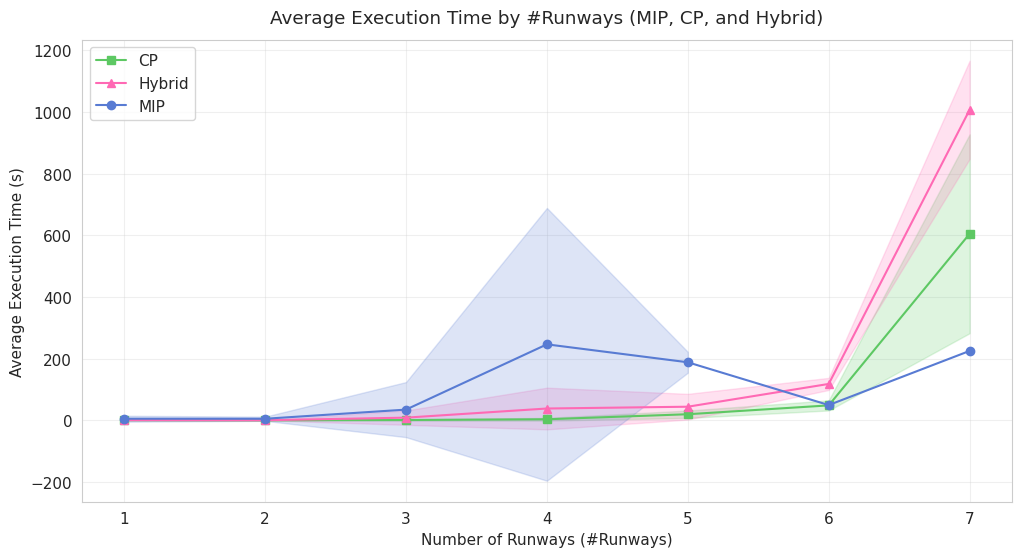

In [176]:
# Filter only solvers of interest and unify names
df_selected_m = df_m[df_m["Solver"].str.contains("MIP|CP|Hybrid")].copy()

df_selected_m["Solver"] = df_selected_m["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

df_selected_m["#Planes"] = pd.to_numeric(df_selected_m["#Planes"])
df_selected_m["#Runways"] = pd.to_numeric(df_selected_m["#Runways"])

summary = df_selected_m.groupby(["Solver", "#Runways"]).agg(
    Time_mean=("Time (s)", "mean"),
    Time_std=("Time (s)", "std"),
    Penalty_mean=("Penalty / Obj", "mean"),
    Penalty_std=("Penalty / Obj", "std")
).reset_index()

# Plot mean Time ± standard deviation
plt.figure(figsize=(12, 6))
for solver in summary["Solver"].unique():
    data = summary[summary["Solver"] == solver]
    plt.plot(data["#Runways"], data["Time_mean"], marker=markers[solver], label=solver, color=custom_colors[solver])
    plt.fill_between(
        data["#Runways"],
        data["Time_mean"] - data["Time_std"],
        data["Time_mean"] + data["Time_std"],
        alpha=0.2,
        color=custom_colors[solver]
    )

plt.xlabel("Number of Runways (#Runways)")
plt.ylabel("Average Execution Time (s)")
plt.title("Average Execution Time by #Runways (MIP, CP, and Hybrid)")
plt.grid(True)
plt.legend()
plt.show()

## Heatmap log10(mean time) per Dataset and Runway type vs Solver

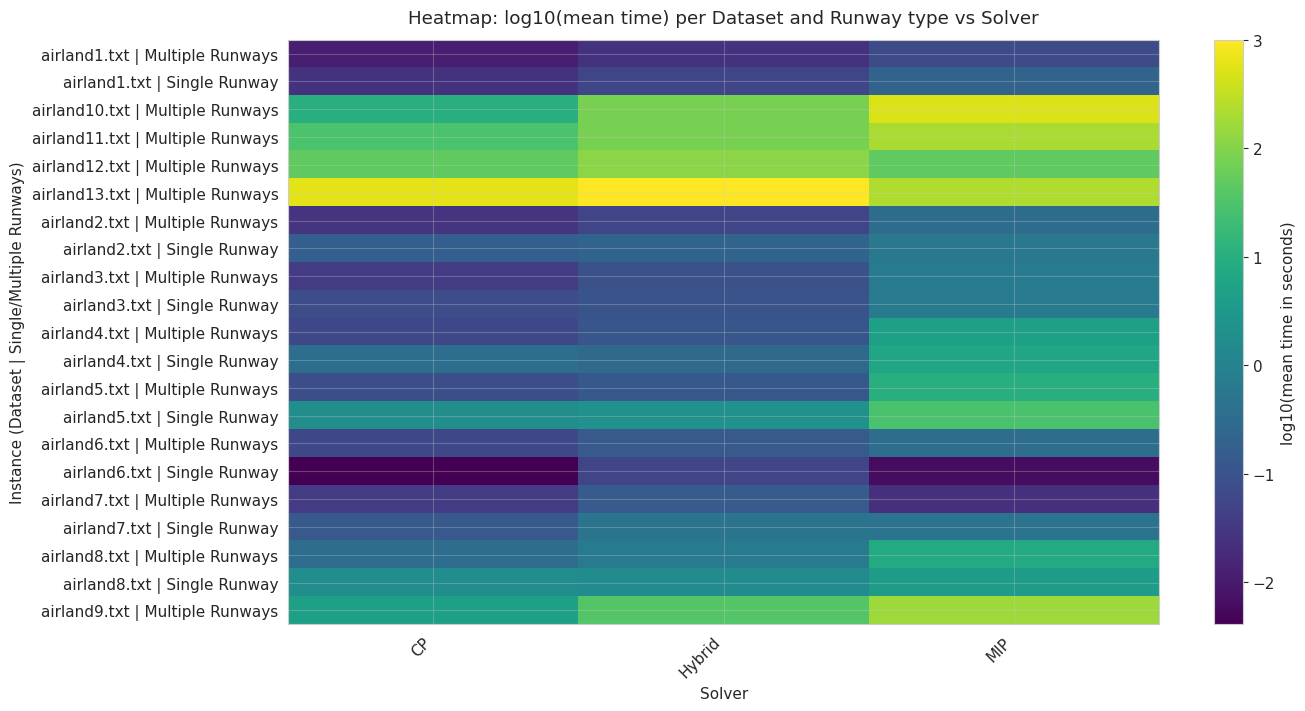

In [177]:
# 1) Group MIP and CP solvers
df_m["Solver_grouped"] = df_m["Solver"].replace({
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "MIP Multiple Large Datasets": "MIP",
    "CP Single": "CP",
    "CP Multiple": "CP",
    "CP Multiple Large Datasets": "CP",
    "Hybrid": "Hybrid",
    "Hybrid Large Datasets": "Hybrid"
})

# 2) Dataset sorting key (airland1, airland2, ...)
def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

# 3) Categorize runways: Single vs Multiple
df_m["Runway_type"] = np.where(df_m["#Runways"] == 1, "Single Runway", "Multiple Runways")

# 4) Create simplified instance ID (Dataset + Runway_type)
df_m["instance_id"] = df_m["Dataset"] + " | " + df_m["Runway_type"]

# Remove rows without time
df_core_m = df_m.dropna(subset=["Time (s)"])

# 5) Aggregate times: mean per Dataset+Runway_type x Solver
pivot_time_grouped = df_core_m.groupby(
    ["instance_id", "Solver_grouped"]
)["Time (s)"].mean().unstack()

# Order columns by median time (fastest first)
col_order_grouped = pivot_time_grouped.median(axis=0, skipna=True).sort_values().index
heat_grouped = pivot_time_grouped[col_order_grouped]

# Log10 for scale compression
heat_log_grouped = np.log10(heat_grouped.to_numpy(dtype=float) + 1e-12)

# Sort datasets numerically
datasets = sorted(df_core_m["Dataset"].unique(), key=dataset_sort_key)

# 6) Heatmap
fig, ax = plt.subplots(figsize=(14, len(heat_grouped)*0.25 + 2))
im = ax.imshow(heat_log_grouped, aspect="auto", cmap="viridis")

ax.set_title("Heatmap: log10(mean time) per Dataset and Runway type vs Solver")
ax.set_xlabel("Solver")
ax.set_ylabel("Instance (Dataset | Single/Multiple Runways)")

ax.set_xticks(np.arange(len(col_order_grouped)))
ax.set_xticklabels(col_order_grouped, rotation=45, ha="right")

# ylabels: all instances
ax.set_yticks(np.arange(len(heat_grouped.index)))
ax.set_yticklabels(heat_grouped.index)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("log10(mean time in seconds)")

plt.tight_layout()
plt.show()


## Number of Variables and Constraints per Solver

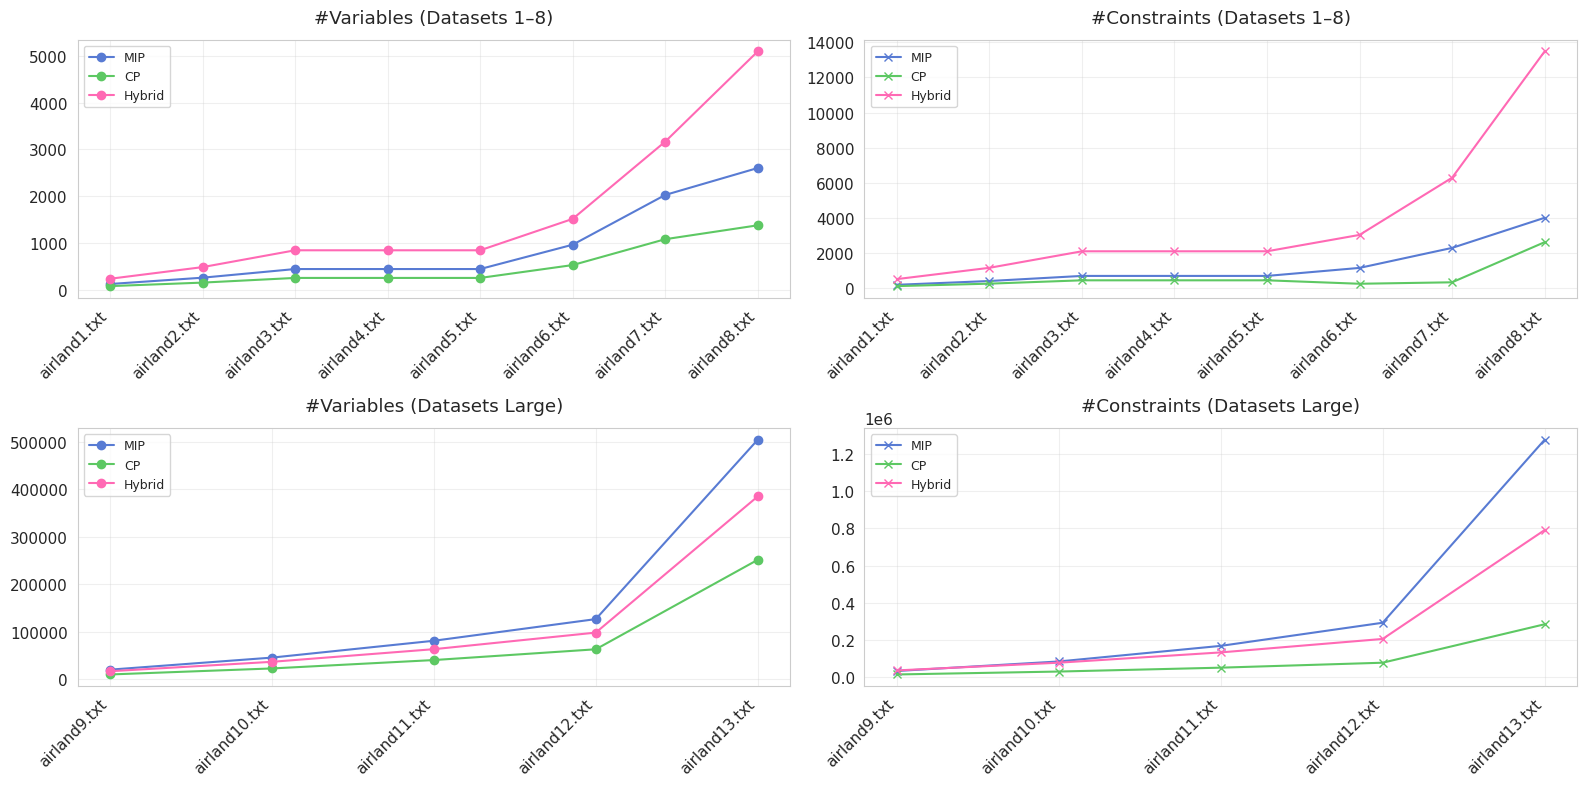

In [178]:
def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

datasets_small = sorted([d for d in df_selected_m["Dataset"].unique() if dataset_sort_key(d) <= 8], key=dataset_sort_key)
datasets_large = sorted([d for d in df_selected_m["Dataset"].unique() if dataset_sort_key(d) > 8], key=dataset_sort_key)

df_selected_m["Solver"] = df_selected_m["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

metrics = ["#Variables", "#Constraints"]
titles = ["#Variables", "#Constraints"]
markers = ['o', 'x', 's', '^']

fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # 2x2 grid

x_small = np.arange(len(datasets_small))
for ax, metric, marker in zip(axes[0], metrics, markers):
    for solver in df_selected_m["Solver"].unique():
        data = df_selected_m[df_selected_m["Solver"] == solver]
        y = [data[data["Dataset"]==d][metric].values[0] if d in data["Dataset"].values else np.nan for d in datasets_small]
        ax.plot(x_small, y, marker=marker, linestyle='-', label=solver, color=custom_colors.get(solver, custom_colors.get(solver, "black")))

    ax.set_title(f"{metric} (Datasets 1–8)")
    ax.set_xticks(x_small)
    ax.set_xticklabels(datasets_small, rotation=45, ha="right")
    ax.grid(True)
    ax.legend(fontsize=9)

x_large = np.arange(len(datasets_large))
for ax, metric, marker in zip(axes[1], metrics, markers):
    for solver in df_selected_m["Solver"].unique():
        data = df_selected_m[df_selected_m["Solver"] == solver]
        y = [data[data["Dataset"]==d][metric].values[0] if d in data["Dataset"].values else np.nan for d in datasets_large]
        ax.plot(x_large, y, marker=marker, linestyle='-', label=solver, color=custom_colors.get(solver, custom_colors.get(solver, "black")))

    ax.set_title(f"{metric} (Datasets Large)")
    ax.set_xticks(x_large)
    ax.set_xticklabels(datasets_large, rotation=45, ha="right")
    ax.grid(True)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


## Overall Comparison

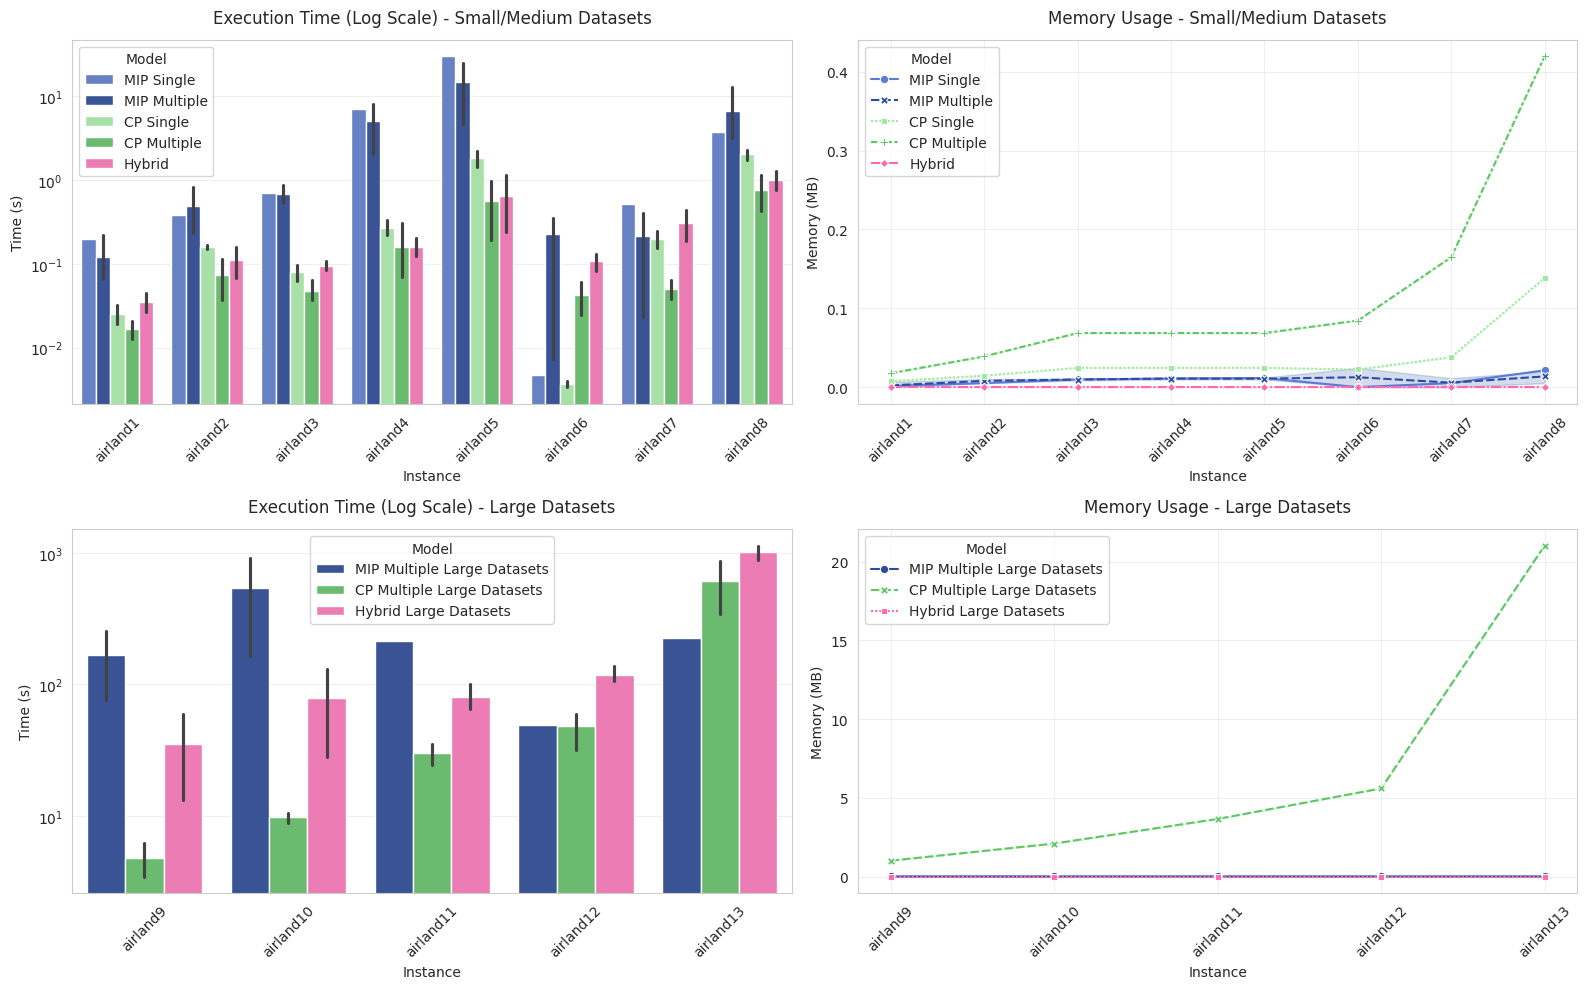

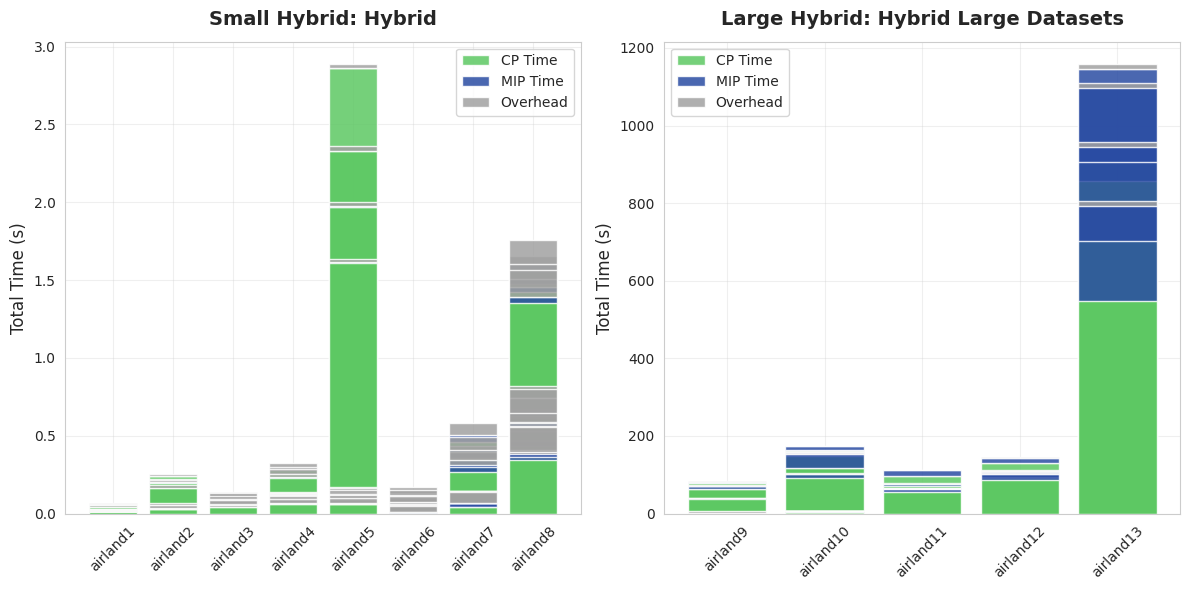

In [179]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# 1. Function to load and process data
def load_metrics_json_overall(path):
    with open(path, 'r') as f:
        data = json.load(f)

    rows = []
    hybrid_rows = []

    for model_name, instances in data.items():
        for inst in instances:
            file_name = inst.get("file", "")
            match = re.search(r'\d+', file_name)
            instance_id = int(match.group()) if match else 0

            exec_time = inst.get("execution_time") or inst.get("total_time", 0)
            mem_usage = inst.get("memory_usage_MB") or inst.get("memory_usage", 0)
            n_vars = inst.get("num_variables", inst.get("cp_num_variables", 0))
            n_cons = inst.get("num_constraints", inst.get("cp_num_constraints", 0))

            rows.append({
                "Model": model_name,
                "Instance": file_name.replace(".txt", ""),
                "ID": instance_id,
                "Time (s)": exec_time,
                "Memory (MB)": mem_usage,
                "Variables": n_vars,
                "Constraints": n_cons
            })

            if "Hybrid" in model_name:
                cp_time = inst.get("cp_time", 0)
                mip_time = inst.get("mip_time", 0)
                total_time = inst.get("total_time", exec_time)

                hybrid_rows.append({
                    "Instance": file_name.replace(".txt", ""),
                    "ID": instance_id,
                    "Model Variant": model_name,
                    "CP Time": cp_time,
                    "MIP Time": mip_time,
                    "Overhead": max(0, total_time - cp_time - mip_time)
                })

    df_all = pd.DataFrame(rows)
    df_hybrid_all = pd.DataFrame(hybrid_rows)
    return df_all, df_hybrid_all

# 2. Function to split datasets
def split_datasets(df_all, df_hybrid_all, small_range=(1,8), large_range=(9,13)):
    df_small = df_all[(df_all["ID"] >= small_range[0]) & (df_all["ID"] <= small_range[1])]
    df_large = df_all[(df_all["ID"] >= large_range[0]) & (df_all["ID"] <= large_range[1])]

    df_hybrid_small = df_hybrid_all[(df_hybrid_all["ID"] >= small_range[0]) & (df_hybrid_all["ID"] <= small_range[1])] if not df_hybrid_all.empty else pd.DataFrame()
    df_hybrid_large = df_hybrid_all[(df_hybrid_all["ID"] >= large_range[0]) & (df_hybrid_all["ID"] <= large_range[1])] if not df_hybrid_all.empty else pd.DataFrame()

    return df_small, df_large, df_hybrid_small, df_hybrid_large

# 3. Function to plot time and memory
def plot_time_memory(df_small, df_large):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Row 0: Small datasets
    # Execution Time Small
    sns.barplot(data=df_small, x="Instance", y="Time (s)", hue="Model", ax=axes[0,0], palette=custom_colors)
    axes[0,0].set_yscale("log")
    axes[0,0].set_title("Execution Time (Log Scale) - Small/Medium Datasets")
    axes[0,0].tick_params(axis='x', rotation=45)

    # Memory Usage Small
    sns.lineplot(data=df_small, x="Instance", y="Memory (MB)", hue="Model", style="Model", markers=True, ax=axes[0,1], palette=custom_colors)
    axes[0,1].set_title("Memory Usage - Small/Medium Datasets")
    axes[0,1].tick_params(axis='x', rotation=45)

    # Row 1: Large datasets
    # Execution Time Large
    sns.barplot(data=df_large, x="Instance", y="Time (s)", hue="Model", ax=axes[1,0], palette=custom_colors)
    axes[1,0].set_yscale("log")
    axes[1,0].set_title("Execution Time (Log Scale) - Large Datasets")
    axes[1,0].tick_params(axis='x', rotation=45)

    # Memory Usage Large
    sns.lineplot(data=df_large, x="Instance", y="Memory (MB)", hue="Model", style="Model", markers=True, ax=axes[1,1], palette=custom_colors)
    axes[1,1].set_title("Memory Usage - Large Datasets")
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# 4. Hybrid Side-by-Side Plot
def plot_hybrid_side_by_side(df_hybrid_small, df_hybrid_large):
    variants_small = df_hybrid_small["Model Variant"].unique() if not df_hybrid_small.empty else []
    variants_large = df_hybrid_large["Model Variant"].unique() if not df_hybrid_large.empty else []

    num_small = len(variants_small)
    num_large = len(variants_large)
    total = num_small + num_large

    if total == 0:
        print("No Hybrid data to plot.")
        return

    fig, axes = plt.subplots(1, total, figsize=(6*total, 6), squeeze=False)

    # Small
    for i, var in enumerate(variants_small):
        subset = df_hybrid_small[df_hybrid_small["Model Variant"] == var]
        x = subset["Instance"]
        axes[0, i].bar(x, subset["CP Time"], label="CP Time", color="#5DC863", alpha=0.85)
        axes[0, i].bar(x, subset["MIP Time"], bottom=subset["CP Time"], label="MIP Time", color="#2A4CA3", alpha=0.85)
        axes[0, i].bar(x, subset["Overhead"], bottom=subset["CP Time"] + subset["MIP Time"], label="Overhead", color="#A1A1A1", alpha=0.85)
        axes[0, i].set_title(f"Small Hybrid: {var}", fontsize=14, fontweight='bold')
        axes[0, i].set_ylabel("Total Time (s)", fontsize=12)
        axes[0, i].tick_params(axis='x', rotation=45)
        if i == 0:
            axes[0, i].legend(fontsize=10)

    # Large
    for j, var in enumerate(variants_large):
        subset = df_hybrid_large[df_hybrid_large["Model Variant"] == var]
        x = subset["Instance"]
        axes[0, num_small + j].bar(x, subset["CP Time"], label="CP Time", color="#5DC863", alpha=0.85)
        axes[0, num_small + j].bar(x, subset["MIP Time"], bottom=subset["CP Time"], label="MIP Time", color="#2A4CA3", alpha=0.85)
        axes[0, num_small + j].bar(x, subset["Overhead"], bottom=subset["CP Time"] + subset["MIP Time"], label="Overhead", color="#A1A1A1", alpha=0.85)
        axes[0, num_small + j].set_title(f"Large Hybrid: {var}", fontsize=14, fontweight='bold')
        axes[0, num_small + j].set_ylabel("Total Time (s)", fontsize=12)
        axes[0, num_small + j].tick_params(axis='x', rotation=45)
        if j == 0:
            axes[0, num_small + j].legend(fontsize=10)

    plt.tight_layout()
    plt.show()

# 5 Visualize
df_all, df_hybrid_all = load_metrics_json_overall('results/metrics.json')
df_small, df_large, df_hybrid_small, df_hybrid_large = split_datasets(df_all, df_hybrid_all)

# Plot Execution Time + Memory
plot_time_memory(df_small, df_large)

# Plot Hybrid lado a lado
plot_hybrid_side_by_side(df_hybrid_small, df_hybrid_large)


## Comparison in Boxplots of Execution Time and Memory Usage

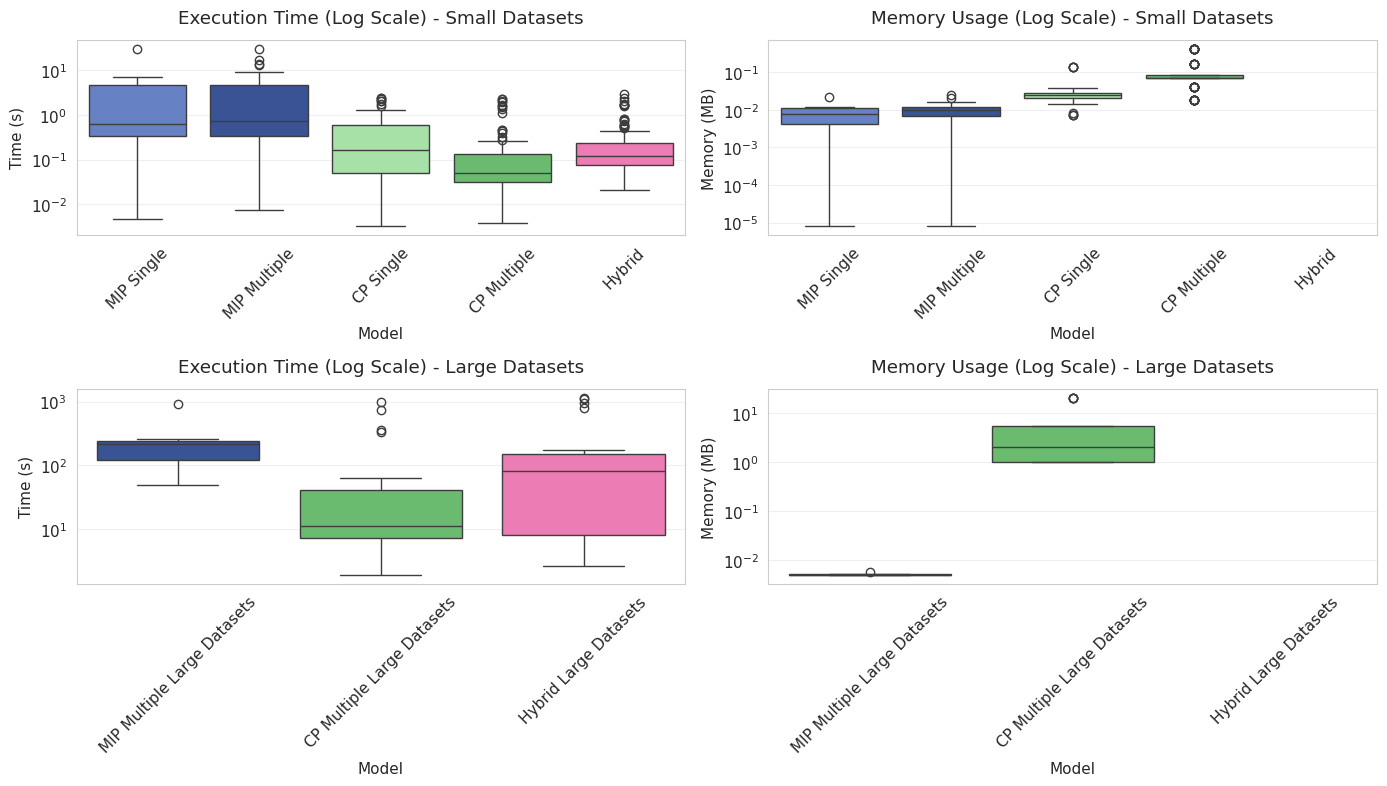

In [180]:
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# 1. Load Data
with open('results/metrics.json', 'r') as f:
    data = json.load(f)

rows = []
hybrid_rows = []

for model_name, instances in data.items():
    for inst in instances:
        file_name = inst.get("file", "").replace(".txt", "")
        match = re.search(r'\d+', file_name)
        instance_id = int(match.group()) if match else 0

        exec_time = inst.get("execution_time") or inst.get("total_time", 0)
        mem_usage = inst.get("memory_usage_MB") or inst.get("memory_usage", 0)
        n_vars = inst.get("num_variables", inst.get("cp_num_variables", 0))
        n_cons = inst.get("num_constraints", inst.get("cp_num_constraints", 0))
        nodes = inst.get("num_branch_and_bound_nodes", 0)
        branches = inst.get("num_branches", inst.get("cp_num_branches", 0))
        conflicts = inst.get("num_conflicts", 0)
        booleans = inst.get("num_booleans", 0)
        total_time = inst.get("total_time", exec_time)

        rows.append({
            "Model": model_name,
            "Instance": file_name,
            "ID": instance_id,
            "Time (s)": exec_time,
            "Memory (MB)": mem_usage,
            "Variables": n_vars,
            "Constraints": n_cons,
            "Branches": branches,
            "Conflicts": conflicts,
            "Booleans": booleans,
            "Nodes": nodes,
            "Problem Size": n_vars + n_cons,
            "Search Steps": max(nodes, branches)
        })

        if "Hybrid" in model_name:
            cp_time = inst.get("cp_time", 0)
            mip_time = inst.get("mip_time", 0)
            hybrid_rows.append({
                "Instance": file_name,
                "ID": instance_id,
                "Model Variant": model_name,
                "CP Time": cp_time,
                "MIP Time": mip_time,
                "Total Time": total_time
            })

df_all = pd.DataFrame(rows)
df_hybrid = pd.DataFrame(hybrid_rows)

# 2. Split Small and Large datasets
df_small = df_all[(df_all["ID"] >= 1) & (df_all["ID"] <= 8)]
df_large = df_all[(df_all["ID"] >= 9) & (df_all["ID"] <= 13)]
df_hybrid_small = df_hybrid[df_hybrid["ID"].between(1,8)] if not df_hybrid.empty else pd.DataFrame()
df_hybrid_large = df_hybrid[df_hybrid["ID"].between(9,13)] if not df_hybrid.empty else pd.DataFrame()

# 3. Boxplots Execution Time / Memory
def plot_boxplots_time_memory(df_small, df_large):
    fig, axes = plt.subplots(2, 2, figsize=(14,8))

    # Execution Time
    sns.boxplot(data=df_small, x="Model", y="Time (s)", palette=custom_colors, ax=axes[0,0])
    axes[0,0].set_yscale("log")
    axes[0,0].set_title("Execution Time (Log Scale) - Small Datasets")

    sns.boxplot(data=df_large, x="Model", y="Time (s)", palette=custom_colors, ax=axes[1,0])
    axes[1,0].set_yscale("log")
    axes[1,0].set_title("Execution Time (Log Scale) - Large Datasets")

    # Memory Usage
    sns.boxplot(data=df_small, x="Model", y="Memory (MB)", palette=custom_colors, ax=axes[0,1])
    axes[0,1].set_yscale("log")
    axes[0,1].set_title("Memory Usage (Log Scale) - Small Datasets")

    sns.boxplot(data=df_large, x="Model", y="Memory (MB)", palette=custom_colors, ax=axes[1,1])
    axes[1,1].set_yscale("log")
    axes[1,1].set_title("Memory Usage (Log Scale) - Large Datasets")

    for ax in axes.flatten():
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_boxplots_time_memory(df_small, df_large)


## Search Effort: MIP Nodes vs CP Branches

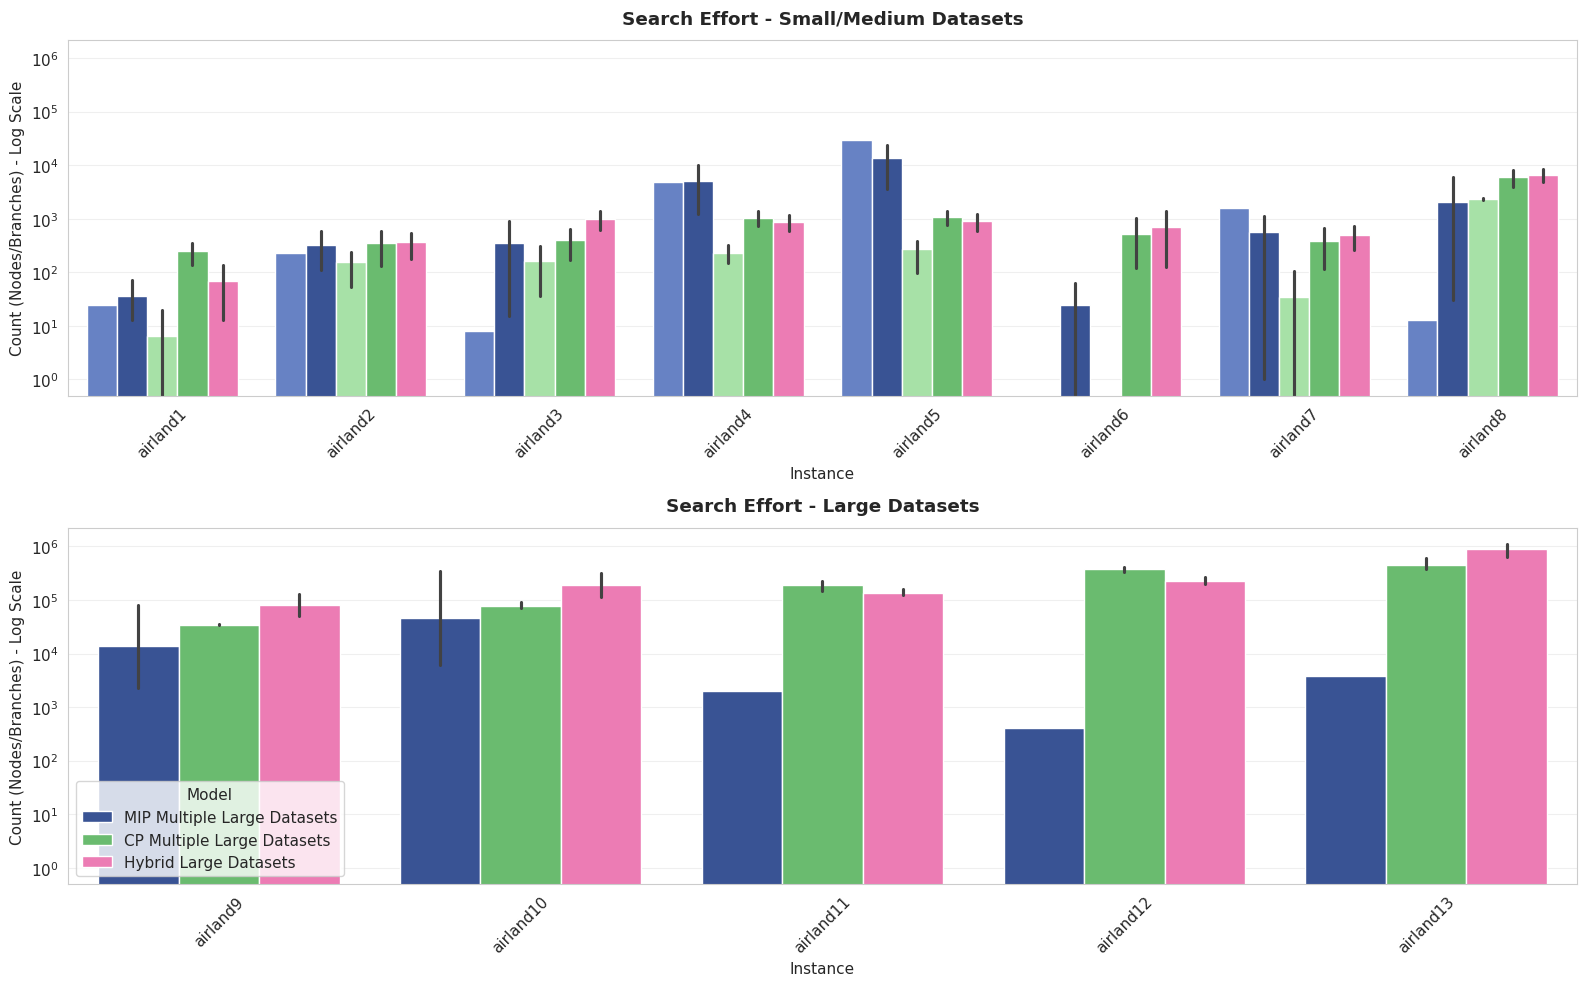

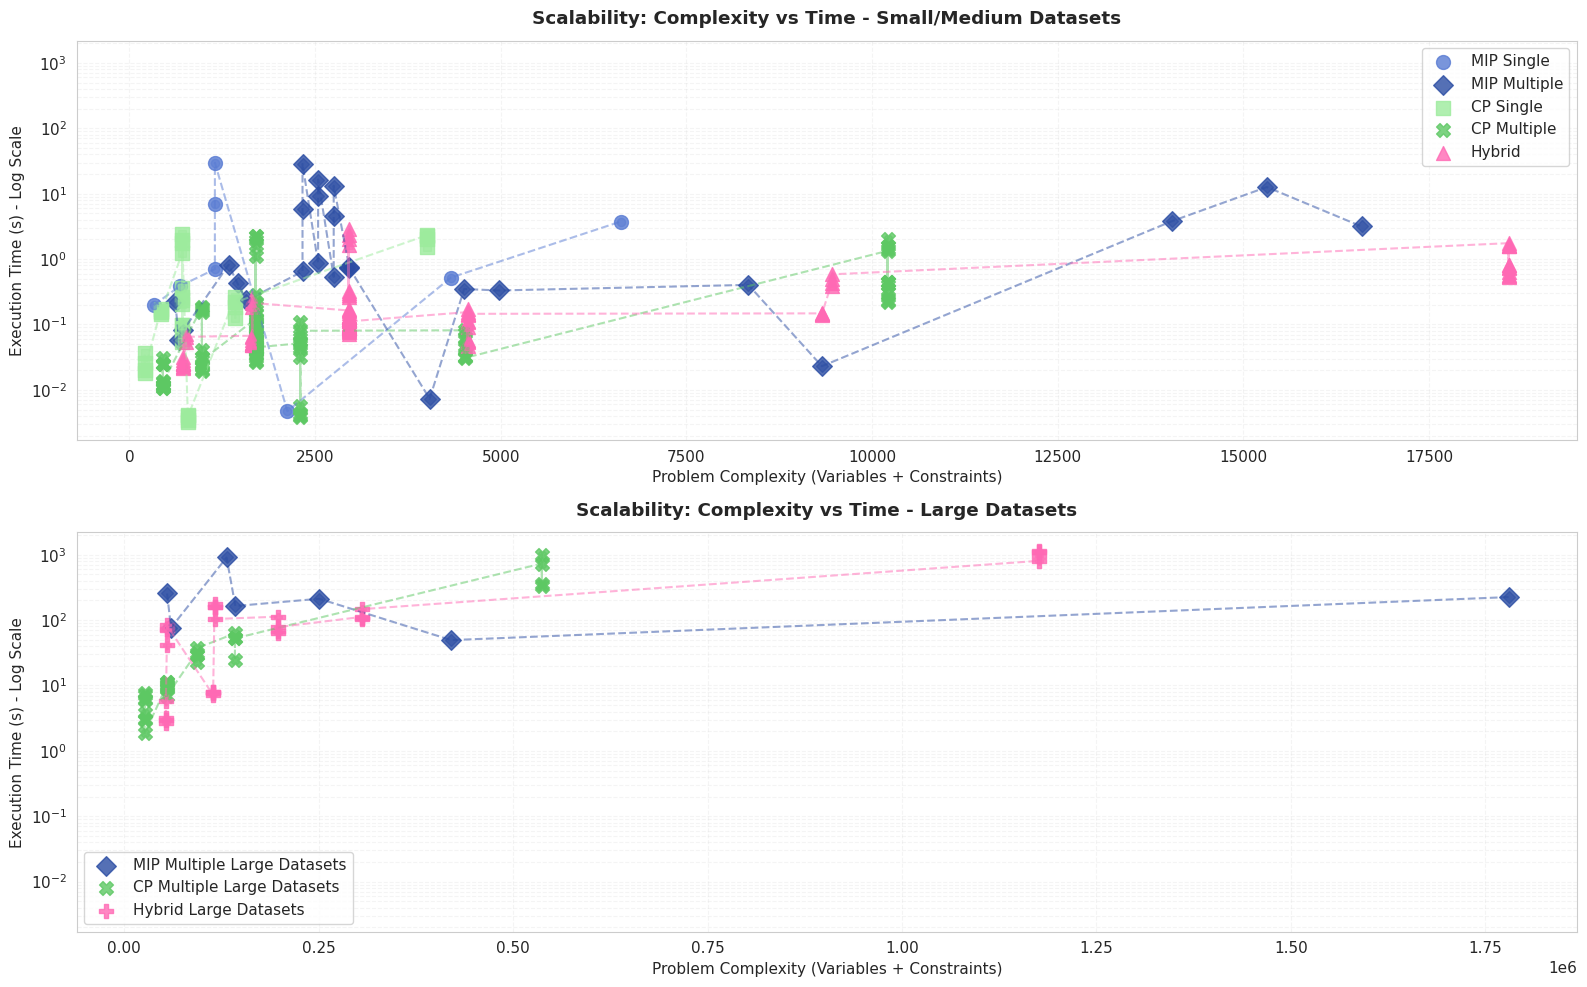

In [181]:
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# 1. Load and process data
def load_metrics_json_overall(path):
    with open(path, 'r') as f:
        data = json.load(f)

    rows = []
    for model_name, instances in data.items():
        for inst in instances:
            file_name = inst.get("file", "").replace(".txt", "")
            match = re.search(r'\d+', file_name)
            instance_id = int(match.group()) if match else 0

            nodes = inst.get("num_branch_and_bound_nodes", 0)
            branches = inst.get("num_branches", inst.get("cp_num_branches", 0))
            search_steps = max(nodes, branches)

            n_vars = inst.get("num_variables", inst.get("cp_num_variables", 0))
            n_cons = inst.get("num_constraints", inst.get("cp_num_constraints", 0))
            problem_size = n_vars + n_cons

            exec_time = inst.get("execution_time") or inst.get("total_time", 0)

            rows.append({
                "Model": model_name,
                "Instance": file_name,
                "ID": instance_id,
                "Search Steps": search_steps,
                "Problem Size": problem_size,
                "Time (s)": exec_time,
            })
    df = pd.DataFrame(rows)
    return df

df_all = load_metrics_json_overall('results/metrics.json')

# 2. Split datasets
df_small = df_all[(df_all["ID"] >= 1) & (df_all["ID"] <= 8)]
df_large = df_all[(df_all["ID"] >= 9) & (df_all["ID"] <= 13)]


# 3. Function to plot search effort
def plot_search_effort(df_small, df_large):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

    # Small datasets
    sns.barplot(data=df_small, x="Instance", y="Search Steps", hue="Model",
                ax=axes[0], palette=custom_colors)
    axes[0].set_yscale("log")
    axes[0].set_title("Search Effort - Small/Medium Datasets", fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel("Count (Nodes/Branches) - Log Scale")

    # Large datasets
    sns.barplot(data=df_large, x="Instance", y="Search Steps", hue="Model",
                ax=axes[1], palette=custom_colors)
    axes[1].set_yscale("log")
    axes[1].set_title("Search Effort - Large Datasets", fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylabel("Count (Nodes/Branches) - Log Scale")

    axes[1].set_xlabel("Instance")
    axes[0].legend().remove()
    axes[1].legend(title="Model")
    plt.tight_layout()
    plt.show()

# 4. Function to plot scalability
def plot_scalability(df_small, df_large):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=False, sharey=True)

    for ax, df_subset, title in zip(axes, [df_small, df_large],
                                    ["Small/Medium Datasets", "Large Datasets"]):
        unique_models = df_subset["Model"].unique()
        for model in unique_models:
            subset = df_subset[df_subset["Model"] == model].sort_values("Problem Size")
            ax.scatter(subset["Problem Size"], subset["Time (s)"],
                       label=model, color=custom_colors.get(model, "#333333"), s=100, alpha=0.8, marker=custom_markers.get(model, "o"))
            if len(subset) > 1:
                ax.plot(subset["Problem Size"], subset["Time (s)"],
                        linestyle="--", alpha=0.5, color=custom_colors.get(model, "#333333"), marker=custom_markers.get(model, "o"))
        ax.set_yscale("log")
        ax.set_title(f"Scalability: Complexity vs Time - {title}", fontweight='bold')
        ax.set_xlabel("Problem Complexity (Variables + Constraints)")
        ax.set_ylabel("Execution Time (s) - Log Scale")
        ax.grid(True, which="both", ls="--", alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()

# 5. Execute plots
plot_search_effort(df_small, df_large)
plot_scalability(df_small, df_large)


## CP: Search Pathology - Decision Tree (Branches) vs Learning (Conflicts)

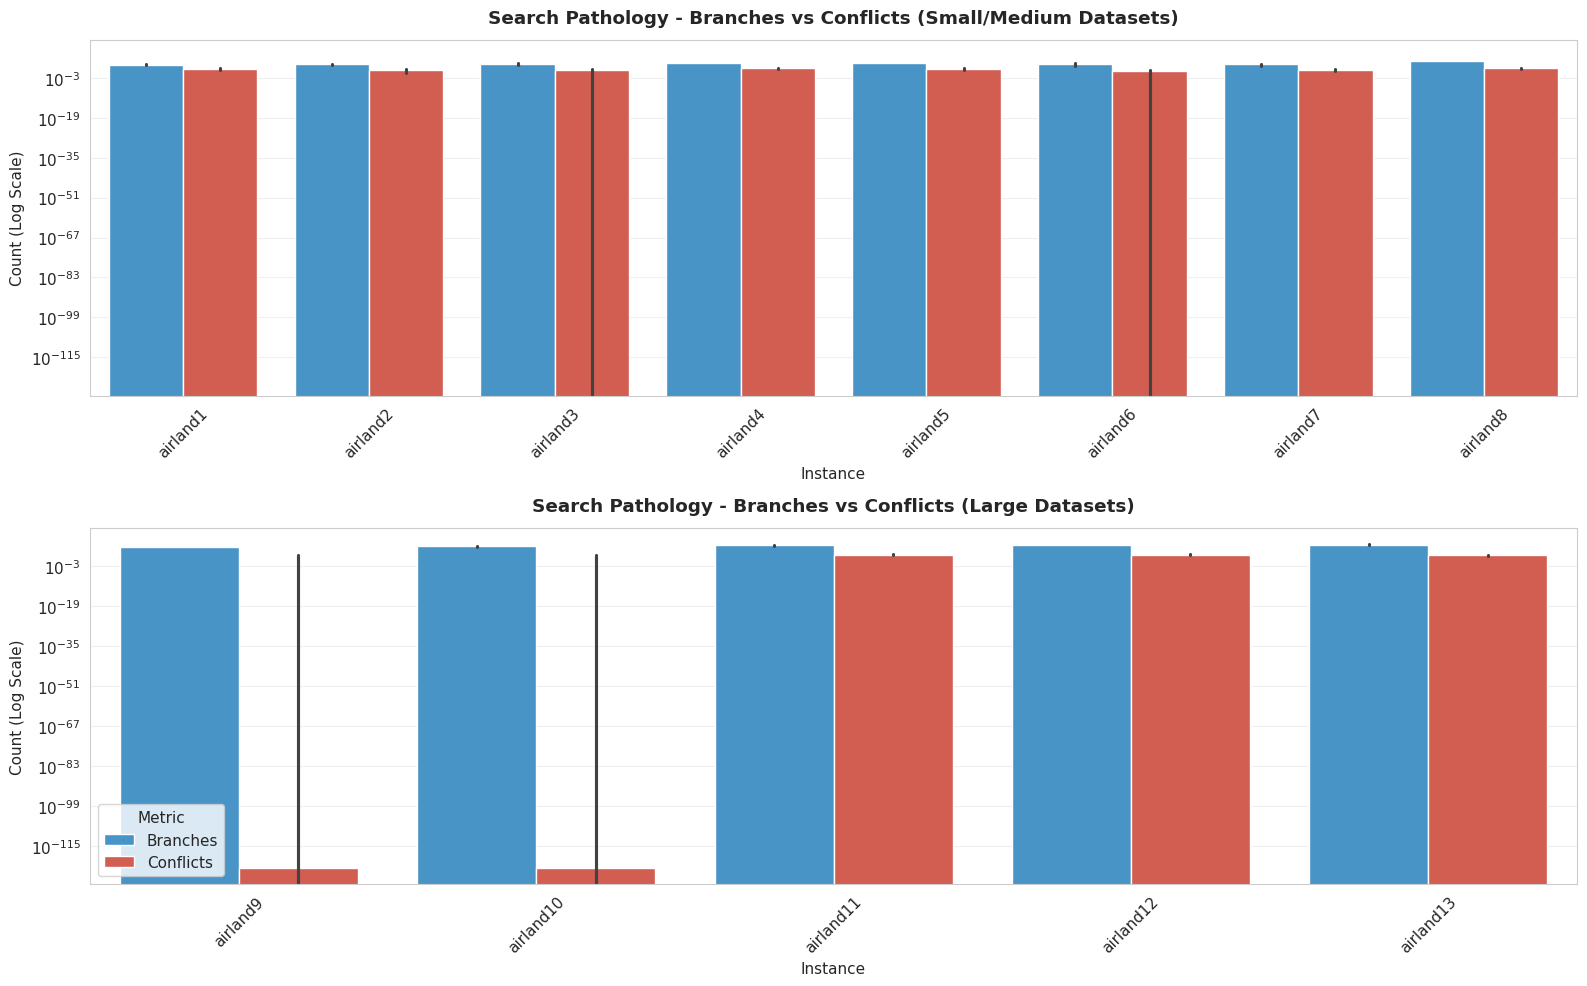

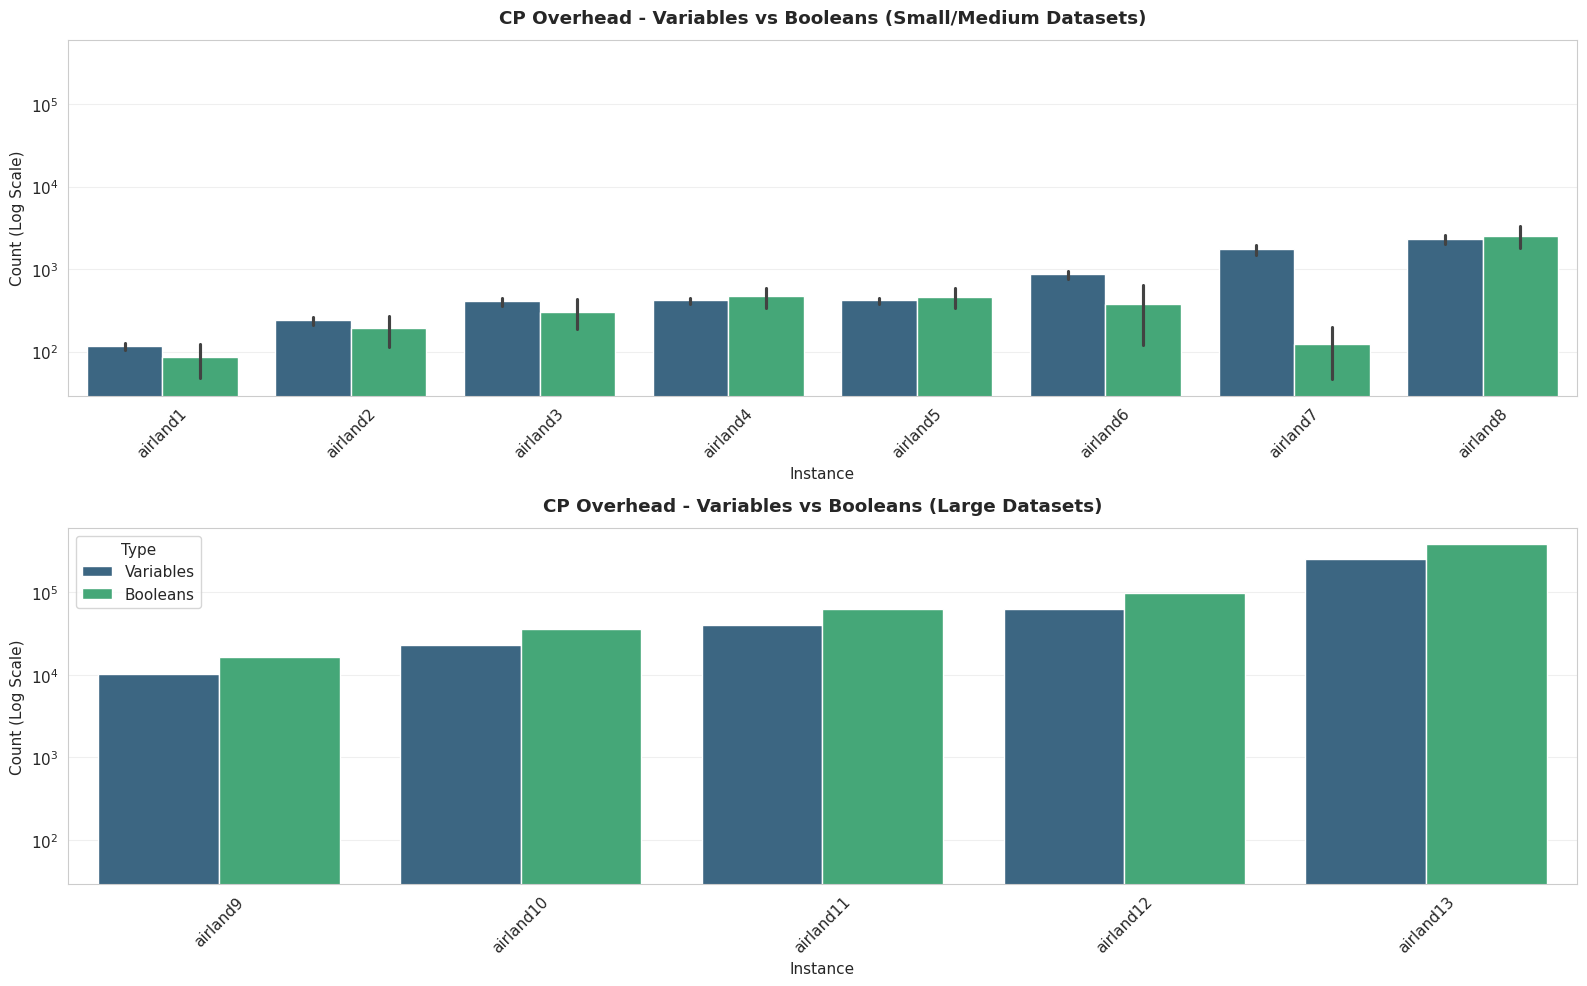

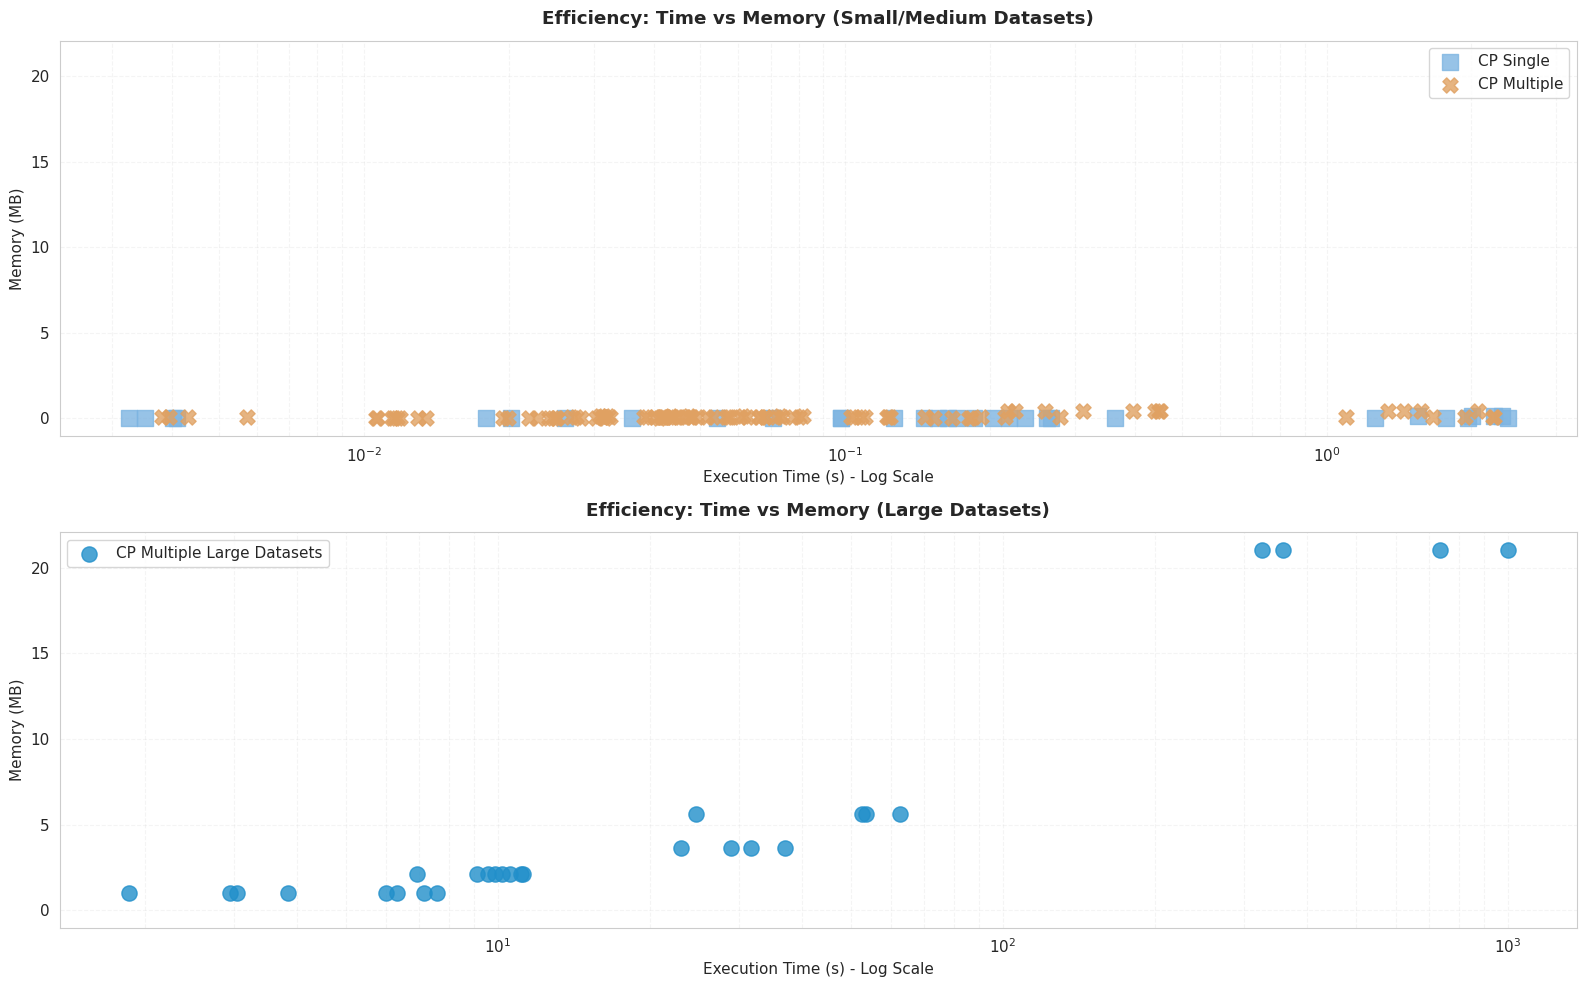

In [182]:
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

# 1. Load Data
def load_cp_metrics(path):
    with open(path, 'r') as f:
        data = json.load(f)

    rows = []
    for model_name, instances in data.items():
        if "CP" not in model_name:
            continue

        for inst in instances:
            file_name = inst.get("file", "").replace(".txt", "")
            match = re.search(r'\d+', file_name)
            instance_id = int(match.group()) if match else 0

            rows.append({
                "Model": model_name,
                "Instance": file_name,
                "ID": instance_id,
                "Variables": inst.get("num_variables", 0),
                "Constraints": inst.get("num_constraints", 0),
                "Booleans": inst.get("num_booleans", 0),
                "Branches": inst.get("num_branches", 0),
                "Conflicts": inst.get("num_conflicts", 0),
                "Time (s)": inst.get("execution_time", 0),
                "Memory (MB)": inst.get("memory_usage", inst.get("memory_usage_MB", 0))
            })
    df = pd.DataFrame(rows)
    return df

df_cp = load_cp_metrics('results/metrics.json')

# Split small/large
df_cp_small = df_cp[(df_cp["ID"] >= 1) & (df_cp["ID"] <= 8)]
df_cp_large = df_cp[(df_cp["ID"] >= 9) & (df_cp["ID"] <= 13)]

# 2. Plot Search Pathology
def plot_search_pathology(df_small, df_large):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

    for ax, df_subset, title in zip(axes, [df_small, df_large], ["Small/Medium Datasets", "Large Datasets"]):
        df_melted = df_subset.melt(id_vars=["Instance", "Model"], value_vars=["Branches", "Conflicts"],
                                   var_name="Metric", value_name="Count")
        sns.barplot(data=df_melted, x="Instance", y="Count", hue="Metric", palette={"Branches": "#3498db", "Conflicts": "#e74c3c"}, ax=ax)
        ax.set_yscale("log")
        ax.set_title(f"Search Pathology - Branches vs Conflicts ({title})", fontweight='bold')
        ax.set_ylabel("Count (Log Scale)")
        ax.tick_params(axis='x', rotation=45)
    axes[1].set_xlabel("Instance")
    axes[0].legend().remove()
    axes[1].legend(title="Metric")
    plt.tight_layout()
    plt.show()

# 3. CP Overhead Plot
def plot_cp_overhead(df_small, df_large):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

    for ax, df_subset, title in zip(axes, [df_small, df_large], ["Small/Medium Datasets", "Large Datasets"]):
        df_melted = df_subset.melt(id_vars=["Instance", "Model"], value_vars=["Variables", "Booleans"],
                                   var_name="Type", value_name="Count")
        sns.barplot(data=df_melted, x="Instance", y="Count", hue="Type", palette="viridis", ax=ax)
        ax.set_yscale("log")
        ax.set_title(f"CP Overhead - Variables vs Booleans ({title})", fontweight='bold')
        ax.set_ylabel("Count (Log Scale)")
        ax.tick_params(axis='x', rotation=45)
    axes[1].set_xlabel("Instance")
    axes[0].legend().remove()
    axes[1].legend(title="Type")
    plt.tight_layout()
    plt.show()

# 4. Plot efficiency: Time vs Memory
def plot_efficiency(df_small, df_large):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

    for ax, df_subset, title in zip(axes, [df_small, df_large], ["Small/Medium Datasets", "Large Datasets"]):
        unique_models = df_subset["Model"].unique()
        for model in unique_models:
            subset = df_subset[df_subset["Model"] == model]
            ax.scatter(subset["Time (s)"], subset["Memory (MB)"],
                       label=model, s=120, alpha=0.8, color={"CP Single": "#7DB4E1", "CP Multiple": "#E0A162"}.get(model, "#218FCA"),
                       marker={"CP Single": "s", "CP Multiple": "X"}.get(model, "o"))
        ax.set_xscale("log")
        ax.set_title(f"Efficiency: Time vs Memory ({title})", fontweight='bold')
        ax.set_xlabel("Execution Time (s) - Log Scale")
        ax.set_ylabel("Memory (MB)")
        ax.grid(True, which="both", ls="--", alpha=0.2)
        ax.legend()
    plt.tight_layout()
    plt.show()

# 5. Execute plots
plot_search_pathology(df_cp_small, df_cp_large)
plot_cp_overhead(df_cp_small, df_cp_large)
plot_efficiency(df_cp_small, df_cp_large)


## CP and Hybrid: Strategy Comparison per Dataset

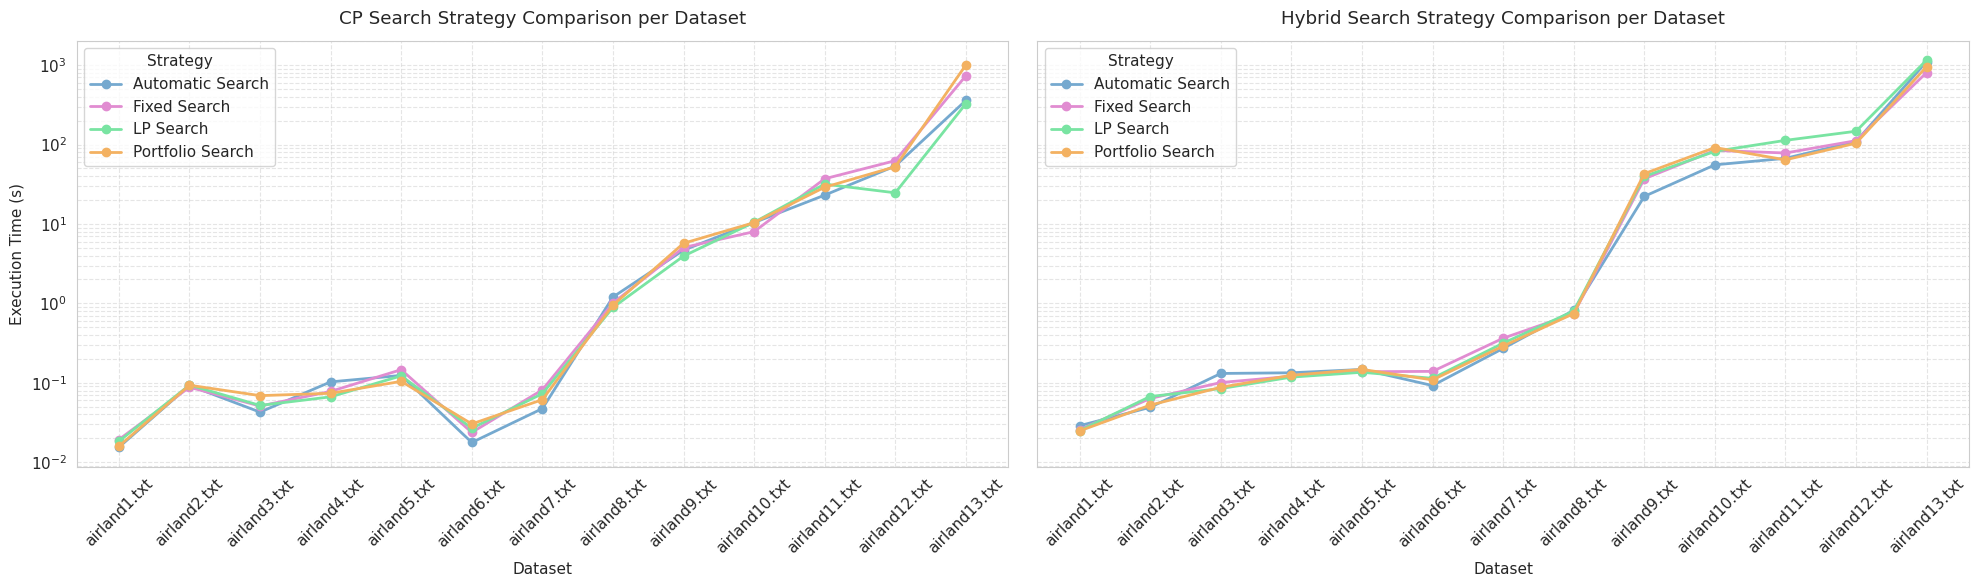

In [183]:
cp_data_m = df_selected_m[df_selected_m["Solver"] == "CP"]

df_ds_strategy = (
    cp_data_m
    .groupby(["Dataset", "Strategy"])["Time (s)"]
    .median()
    .reset_index()
)

hybrid_data_m = df_selected_m[df_selected_m["Solver"] == "Hybrid"]

df_hybrid_strategy = (
    hybrid_data_m
    .groupby(["Dataset", "Strategy"])["Time (s)"]
    .median()
    .reset_index()
)

def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

datasets_cp = sorted(df_ds_strategy["Dataset"].unique(), key=dataset_sort_key)
datasets_hybrid = sorted(df_hybrid_strategy["Dataset"].unique(), key=dataset_sort_key)

x_cp = np.arange(len(datasets_cp))
x_hybrid = np.arange(len(datasets_hybrid))

strategies_cp = df_ds_strategy["Strategy"].unique()
strategies_hybrid = df_hybrid_strategy["Strategy"].unique()

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for strategy in strategies_cp:
    strat_data = (
        df_ds_strategy[df_ds_strategy["Strategy"] == strategy]
        .set_index("Dataset")
        .reindex(datasets_cp)
    )
    axes[0].plot(
        x_cp,
        strat_data["Time (s)"],
        marker="o",
        linewidth=2,
        label=strategy,
        color=strategy_colors[strategy]
    )

axes[0].set_yscale("log")
axes[0].set_xticks(x_cp)
axes[0].set_xticklabels(datasets_cp, rotation=45)
axes[0].set_xlabel("Dataset")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_title("CP Search Strategy Comparison per Dataset")
axes[0].grid(True, which="both", linestyle="--", alpha=0.5)
axes[0].legend(title="Strategy")

for strategy in strategies_hybrid:
    strat_data = (
        df_hybrid_strategy[df_hybrid_strategy["Strategy"] == strategy]
        .set_index("Dataset")
        .reindex(datasets_hybrid)
    )
    axes[1].plot(
        x_hybrid,
        strat_data["Time (s)"],
        marker="o",
        linewidth=2,
        label=strategy,
        color=strategy_colors[strategy]
    )

axes[1].set_yscale("log")
axes[1].set_xticks(x_hybrid)
axes[1].set_xticklabels(datasets_hybrid, rotation=45)
axes[1].set_xlabel("Dataset")
axes[1].set_title("Hybrid Search Strategy Comparison per Dataset")
axes[1].grid(True, which="both", linestyle="--", alpha=0.5)
axes[1].legend(title="Strategy")

plt.tight_layout()
plt.show()
